# Advancing Pediatric Heart Transplantation

In [89]:
# Libraries
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from IPython.display import display
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from scipy.stats import spearmanr, pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from pandas.errors import SettingWithCopyWarning
from sklearn.impute import KNNImputer
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from scipy.stats import pointbiserialr, spearmanr
from scipy.stats import ttest_ind, chi2_contingency, fisher_exact
from scipy.stats import f_oneway, chi2_contingency, fisher_exact

In [3]:
# Define the file path
file_path = r"C:\Users\chris\OneDrive\Desktop\Deep Learning Project\organ-retrieval-and-collection-of-health-information-for-donation-orchid-2.0.0\cleanedcombineddata.csv"

# Read the CSV into a DataFrame
data = pd.read_csv(file_path)

# Display the first few rows to confirm
print(data.head())

    OPO     PatientID   Age  Gender   HospitalID  brain_death  ABO_Rh  \
0  OPO1  OPO1_P320866  62.0     1.0  OPO1_H23456            0     NaN   
1  OPO1  OPO1_P549364  14.0     0.0  OPO1_H11908            0     NaN   
2  OPO1  OPO1_P536997  55.0     1.0  OPO1_H23111            0     NaN   
3  OPO1  OPO1_P463285  48.0     0.0  OPO1_H26589            0     NaN   
4  OPO1  OPO1_P284978  80.0     0.0   OPO1_H5832            0     NaN   

    HeightIn    WeightKg  approached  ...  ABO_BloodType_A1B  \
0  68.000000   70.000000           0  ...                  0   
1  61.023622   70.500000           0  ...                  0   
2  70.000000   89.500000           1  ...                  0   
3  54.000000   50.340136           0  ...                  0   
4  64.000000  136.500000           0  ...                  0   

   ABO_BloodType_A2  ABO_BloodType_A2B  ABO_BloodType_AB  ABO_BloodType_B  \
0                 0                  0                 0                0   
1                 0   

In [4]:
# Total rows and columns
print("Shape of data:", data.shape)  # (rows, columns)

# Total number of columns
print("Total columns:", len(data.columns))


Shape of data: (133101, 390)
Total columns: 390


# Pre-Processing

#### Filter Peds Cardiac Transplant

In [7]:
# Define columns
heart_cols = [
    'approached', 'authorized', 'procured', 'transplanted',
    'outcome_heart_Recovered for Research',
    'outcome_heart_Recovered for Transplant but not Transplanted',
    'outcome_heart_Transplanted'
]

non_heart_cols = [
    'outcome_liver_Recovered for Research', 'outcome_liver_Recovered for Transplant but not Transplanted', 'outcome_liver_Transplanted',
    'outcome_kidney_left_Recovered for Research', 'outcome_kidney_left_Recovered for Transplant but not Transplanted', 'outcome_kidney_left_Transplanted',
    'outcome_kidney_right_Recovered for Research', 'outcome_kidney_right_Recovered for Transplant but not Transplanted', 'outcome_kidney_right_Transplanted',
    'outcome_lung_left_Recovered for Research', 'outcome_lung_left_Recovered for Transplant but not Transplanted', 'outcome_lung_left_Transplanted',
    'outcome_lung_right_Recovered for Research', 'outcome_lung_right_Recovered for Transplant but not Transplanted', 'outcome_lung_right_Transplanted',
    'outcome_intestine_Recovered for Research', 'outcome_intestine_Recovered for Transplant but not Transplanted', 'outcome_intestine_Transplanted',
    'outcome_pancreas_Recovered for Research', 'outcome_pancreas_Recovered for Transplant but not Transplanted', 'outcome_pancreas_Transplanted'
]

# Filter age < 18
peds = data[data['Age'] < 18]

# Identify those with heart transplant activity
has_heart_activity = peds[heart_cols].fillna(0).sum(axis=1) > 0

# Identify those with other organ transplant activity
has_non_heart_activity = peds[non_heart_cols].fillna(0).sum(axis=1) > 0

#  Keep only patients with heart activity, regardless of other activity
peds_heart = peds[has_heart_activity]

# Summary counts
transplanted = (peds_heart['outcome_heart_Transplanted'] == 1).sum()
not_transplanted = (peds_heart['outcome_heart_Transplanted'] != 1).sum()

print("Pediatric patients (<18) with heart transplant activity:", len(peds_heart))
print(" Transplanted:", transplanted)
print(" Not Transplanted:", not_transplanted)

Pediatric patients (<18) with heart transplant activity: 1347
 Transplanted: 441
 Not Transplanted: 906


#### Parse the time values

In [9]:

# Function to parse time strings like '15:00.0' (MM:SS.s) into total seconds
def parse_time_string(time_str):
    if pd.isna(time_str) or str(time_str).strip() == '':
        return np.nan
    try:
        parts = str(time_str).split(':')
        if len(parts) == 2:
            minutes = float(parts[0])
            seconds = float(parts[1])
            return minutes * 60 + seconds
    except:
        pass
    return np.nan

# Work on a copy or directly on peds_heart
df = peds_heart.copy()

# List of your time columns
time_cols = [
    'time_asystole', 'time_brain_death', 'time_referred',
    'time_approached', 'time_authorized', 'time_procured'
]

#  Parse each into a "_seconds" column
for col in time_cols:
    sec_col = f'{col}_seconds'
    if col in df.columns:
        df[sec_col] = df[col].apply(parse_time_string)

#  Compute intervals (in hours)
df['hours_asystole_to_referred']       = (df['time_referred_seconds']   - df['time_asystole_seconds'])   / 3600
df['hours_brain_death_to_referred']    = (df['time_referred_seconds']   - df['time_brain_death_seconds']) / 3600
df['hours_referred_to_approached']     = (df['time_approached_seconds'] - df['time_referred_seconds'])   / 3600
df['hours_approached_to_authorized']   = (df['time_authorized_seconds'] - df['time_approached_seconds']) / 3600
df['hours_authorized_to_procured']     = (df['time_procured_seconds']   - df['time_authorized_seconds']) / 3600

# Clean up intermediate seconds columns if you don't need them
df.drop(columns=[f'{col}_seconds' for col in time_cols], inplace=True, errors='ignore')

#  Inspect the new duration columns
print(df[[
    'hours_asystole_to_referred',
    'hours_brain_death_to_referred',
    'hours_referred_to_approached',
    'hours_approached_to_authorized',
    'hours_authorized_to_procured'
]].head())

     hours_asystole_to_referred  hours_brain_death_to_referred  \
112                         NaN                      -0.200000   
131                         NaN                       0.450583   
176                         NaN                      -0.202750   
240                         NaN                            NaN   
262                         NaN                            NaN   

     hours_referred_to_approached  hours_approached_to_authorized  \
112                      0.450000                            0.00   
131                     -0.117250                            0.25   
176                     -0.180583                            0.00   
240                           NaN                             NaN   
262                           NaN                             NaN   

     hours_authorized_to_procured  
112                      0.116667  
131                     -0.150000  
176                      0.366667  
240                           NaN  
262     

In [10]:


warnings.simplefilter("ignore", SettingWithCopyWarning)

time_cols = [
    'time_asystole',
    'time_brain_death',
    'time_referred',
    'time_approached',
    'time_authorized',
    'time_procured'
]

def parse_minsec(x):
    if pd.isna(x) or str(x).strip() == '':
        return np.nan
    try:
        m, s = str(x).split(':')
        return int(m) * 60 + float(s)
    except:
        return np.nan

for col in time_cols:
    peds_heart[f'{col}_seconds_orig'] = peds_heart[col].map(parse_minsec)
    peds_heart[f'{col}_seconds']      = peds_heart[f'{col}_seconds_orig']

sec_cols = [f'{c}_seconds' for c in time_cols]

imputer = KNNImputer(n_neighbors=5)
peds_heart.loc[:, sec_cols] = imputer.fit_transform(peds_heart[sec_cols])

dur_map = {
    'hours_asystole_to_referred':    ('time_asystole_seconds',    'time_referred_seconds'),
    'hours_brain_death_to_referred': ('time_brain_death_seconds', 'time_referred_seconds'),
    'hours_referred_to_approached':  ('time_referred_seconds',    'time_approached_seconds'),
    'hours_approached_to_authorized':('time_approached_seconds',  'time_authorized_seconds'),
    'hours_authorized_to_procured':  ('time_authorized_seconds',  'time_procured_seconds')
}

for dur_col, (start, end) in dur_map.items():
    peds_heart[f'{dur_col}_orig'] = (peds_heart[end] - peds_heart[start]) / 3600
    peds_heart[dur_col] = peds_heart[f'{dur_col}_orig'].abs()

orig_cols  = [f'{dur}_orig' for dur in dur_map]
after_cols = list(dur_map.keys())

mean_before = peds_heart[orig_cols].mean().rename('mean_before_hours')
mean_after  = peds_heart[after_cols].mean().rename('mean_after_hours')

print("Means before vs. after correcting negatives:")
print(pd.concat([mean_before, mean_after], axis=1).round(3))

print("\nRemaining NaNs in seconds:")
print(peds_heart[sec_cols].isna().sum().to_dict())
print("Remaining NaNs in durations:")
print(peds_heart[after_cols].isna().sum().to_dict())

Means before vs. after correcting negatives:
                                     mean_before_hours  mean_after_hours
hours_asystole_to_referred_orig                  0.039               NaN
hours_brain_death_to_referred_orig               0.029               NaN
hours_referred_to_approached_orig               -0.159               NaN
hours_approached_to_authorized_orig              0.064               NaN
hours_authorized_to_procured_orig                0.056               NaN
hours_asystole_to_referred                         NaN             0.239
hours_brain_death_to_referred                      NaN             0.263
hours_referred_to_approached                       NaN             0.306
hours_approached_to_authorized                     NaN             0.115
hours_authorized_to_procured                       NaN             0.235

Remaining NaNs in seconds:
{'time_asystole_seconds': 0, 'time_brain_death_seconds': 0, 'time_referred_seconds': 0, 'time_approached_seconds': 0, 'time_

In [11]:
# Define  duration mapping
dur_map = {
    'hours_asystole_to_referred':    ('time_asystole_seconds',    'time_referred_seconds'),
    'hours_brain_death_to_referred': ('time_brain_death_seconds', 'time_referred_seconds'),
    'hours_referred_to_approached':  ('time_referred_seconds',    'time_approached_seconds'),
    'hours_approached_to_authorized':('time_approached_seconds',  'time_authorized_seconds'),
    'hours_authorized_to_procured':  ('time_authorized_seconds',  'time_procured_seconds')
}

# Build a summary DataFrame
intervals = list(dur_map.keys())
summary_df = pd.DataFrame(index=intervals, columns=['mean_before_hours', 'mean_after_hours'])

for dur in intervals:
    summary_df.loc[dur, 'mean_before_hours'] = peds_heart[f'{dur}_orig'].mean()
    summary_df.loc[dur, 'mean_after_hours']  = peds_heart[dur].mean()

# Compute the change and round
summary_df['mean_diff_hours'] = summary_df['mean_after_hours'] - summary_df['mean_before_hours']
summary_df = summary_df.astype(float).round(3)

# Display the result
print("Means before vs. after correcting negatives:")
print(summary_df)

# Clean up intermediate columns
orig_cols = [f'{dur}_orig' for dur in intervals] \
          + [f'{col}_seconds_orig' for col in time_cols]
peds_heart.drop(columns=orig_cols, inplace=True, errors='ignore')

Means before vs. after correcting negatives:
                                mean_before_hours  mean_after_hours  \
hours_asystole_to_referred                  0.039             0.239   
hours_brain_death_to_referred               0.029             0.263   
hours_referred_to_approached               -0.159             0.306   
hours_approached_to_authorized              0.064             0.115   
hours_authorized_to_procured                0.056             0.235   

                                mean_diff_hours  
hours_asystole_to_referred                0.200  
hours_brain_death_to_referred             0.233  
hours_referred_to_approached              0.465  
hours_approached_to_authorized            0.051  
hours_authorized_to_procured              0.180  


In [12]:
# Drop the original MM:SS.s string columns
peds_heart.drop(
    columns=[
        'time_asystole',
        'time_brain_death',
        'time_referred',
        'time_approached',
        'time_authorized',
        'time_procured'
    ],
    inplace=True,
    errors='ignore'
)


We converted each of the six raw MM:SS.s time‑string fields (asystole, brain‑death, referred, approached, authorized, procured) into numeric “seconds” values, preserving the original parsed results in _seconds_orig columns and copying them into working _seconds columns. We then used a 5‑nearest‑neighbor imputer to fill any missing seconds across all six variables in one pass, guaranteeing a complete dataset of event times. Next, we calculated five inter‑event durations in hours—first as signed differences (stored in *_orig duration columns) and then replaced each with its absolute value to correct any inadvertent timestamp reversals. We printed a before‑and‑after comparison of each interval’s mean to quantify how much those corrections shifted our averages, confirmed that no NaNs remain in either the imputed seconds or the final duration columns, and finally cleaned up by dropping all the intermediate “orig” and original string fields, leaving only the clean, positive‑valued duration variables ready for analysis.

#### Missing Values

In [15]:
# Compute missing value counts and percentages
missing_counts = peds_heart.isna().sum()
missing_df = missing_counts[missing_counts > 0].to_frame('missing_count')
missing_df['missing_pct'] = (missing_df['missing_count'] / len(peds_heart) * 100).round(2)

# Sort and display
missing_df = missing_df.sort_values('missing_count', ascending=False)
print(missing_df)

              missing_count  missing_pct
TotalMB                1346        99.93
SerumBetaHCG           1346        99.93
TroponinT              1343        99.70
BNP                    1341        99.55
CpkIndex               1340        99.48
...                     ...          ...
EBV_IgG                 528        39.20
EBV IgM                 528        39.20
WNV RNA                 528        39.20
HeightIn                180        13.36
WeightKg                 26         1.93

[178 rows x 2 columns]


In [16]:
# Calculate the fraction of missing values in each column
missing_frac = peds_heart.isna().mean()

# Identify columns with >50% missing
cols_to_drop = missing_frac[missing_frac > 0.50].index.tolist()

# Drop them in place
peds_heart.drop(columns=cols_to_drop, inplace=True)

print(f"Dropped {len(cols_to_drop)} columns with >50% missing:")
print(cols_to_drop)


Dropped 79 columns with >50% missing:
['ABO_Rh', 'PH', 'PCO2', 'PO2', 'HCO3', 'BE', 'FIO2', 'O2SAT', 'PIP', 'PEEP', 'TV', 'Rate', 'mode_A/C', 'mode_APRV', 'mode_Apnea Test', 'mode_BiPAP', 'mode_CMV', 'mode_CPAP', 'mode_HFOV', 'mode_NC', 'mode_Other', 'mode_PC', 'mode_PRVC', 'mode_SIMV', 'mode_nan', 'WBC', 'Hct', 'Hgb', 'Ptl', 'Band', 'Segs', 'Lymp', 'Mono', 'Eos', 'RBC', 'Albumin', 'AlkPhos', 'Amylase', 'BNP', 'BUN', 'CI', 'CKMB', 'CO2', 'Calcium', 'Cpk', 'CpkIndex', 'Creatinine', 'CreatinineClearance', 'DirectBili', 'Fibrinogen', 'GGT', 'Glucose', 'HgbA1C', 'INR', 'IndirectBili', 'IonizedCalcium', 'K', 'LDH', 'Lactate', 'Lipase', 'LipaseULN', 'Mg', 'PT', 'PTT', 'Phosphorous', 'SGOTAST', 'SGPTALT', 'SerumBetaHCG', 'SerumOsmo', 'TotalBili', 'TotalMB', 'TotalProtein', 'TroponinI', 'TroponinT', 'DBP', 'HR', 'SBP', 'Temp', 'UOP']


In [17]:

# Split into train/test to avoid leakage
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['transplanted'],
    random_state=42
)

# Identify numeric columns with missing values
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
to_impute = [c for c in num_cols if train_df[c].isna().any()]

# Record means before imputation (training set)
means_before = train_df[to_impute].mean()

# Fit KNN imputer on train and transform both train & test
imputer = KNNImputer(n_neighbors=5)
train_df.loc[:, to_impute] = imputer.fit_transform(train_df[to_impute])
test_df.loc[:,  to_impute] = imputer.transform(test_df[to_impute])

# Ensure no negative values in duration columns
dur_cols = [c for c in train_df.columns if c.startswith('hours_')]
for c in dur_cols:
    train_df[c] = train_df[c].abs()
    test_df[c]  = test_df[c].abs()

# Record means after imputation (training set)
means_after = train_df[to_impute].mean()

# Summarize the change
summary = pd.DataFrame({
    'mean_before': means_before.round(3),
    'mean_after':  means_after.round(3)
})
summary['mean_diff'] = (summary['mean_after'] - summary['mean_before']).round(3)

print("Mean Before vs. After KNN Imputation (Training Set):")
print(summary)

Mean Before vs. After KNN Imputation (Training Set):
                                mean_before  mean_after  mean_diff
ABO_Rh                                0.922       0.948      0.026
HeightIn                             48.866      48.411     -0.455
WeightKg                             37.007      37.070      0.063
Procured_Year                      2018.152    2018.157      0.005
PH                                    7.347       7.330     -0.017
...                                     ...         ...        ...
hours_asystole_to_referred            0.035       0.295      0.260
hours_brain_death_to_referred         0.030       0.243      0.213
hours_referred_to_approached         -0.139       0.303      0.442
hours_approached_to_authorized        0.057       0.117      0.060
hours_authorized_to_procured          0.051       0.241      0.190

[183 rows x 3 columns]


#### Categorical Variables One Hot Encoding

In [19]:
# Drop the unneeded ID columns
peds_heart.drop(
    columns=['PatientID', 'HospitalID'],
    inplace=True,
    errors='ignore'
)


In [20]:
# One‑hot–encode OPO
peds_heart = pd.get_dummies(
    peds_heart,
    columns=['OPO'],
    prefix='OPO',
    prefix_sep='_',
    drop_first=False   # set to True if you want to drop one level per variable
)

# Verify the new dummy columns
new_opo_cols = [c for c in peds_heart.columns if c.startswith('OPO_')]
print("OPO one‑hot columns:")
print(new_opo_cols)


OPO one‑hot columns:
['OPO_OPO1', 'OPO_OPO2', 'OPO_OPO3', 'OPO_OPO4', 'OPO_OPO5', 'OPO_OPO6']


In [21]:
# Identify columns where every value is exactly zero
zero_cols = peds_heart.columns[peds_heart.eq(0).all()]

# Drop those all‑zero columns in place
peds_heart.drop(columns=zero_cols, inplace=True)

# Report which columns were removed
print(f"Dropped {len(zero_cols)} all‑zero columns:")
print(zero_cols.tolist())



Dropped 67 all‑zero columns:
['outcome_intestine_Recovered for Transplant but not Transplanted', 'Cause_of_Death_OPO_AAA - abdominal aortic aneurysm', 'Cause_of_Death_OPO_AAA or thoracic AA', 'Cause_of_Death_OPO_AIDS/HIV', 'Cause_of_Death_OPO_An -  hanging', 'Cause_of_Death_OPO_Aneurysm', 'Cause_of_Death_OPO_Arrhythmia', 'Cause_of_Death_OPO_CAR - CHF', 'Cause_of_Death_OPO_CAR - MI', 'Cause_of_Death_OPO_CAR - arrhythmia', 'Cause_of_Death_OPO_CAR - cardiomegaly/cardiomyopathy/cardiovascular', 'Cause_of_Death_OPO_CAR - probable MI', 'Cause_of_Death_OPO_CHF', 'Cause_of_Death_OPO_COPD', 'Cause_of_Death_OPO_Cancer', 'Cause_of_Death_OPO_Cancer - Leukemia/Lymphoma', 'Cause_of_Death_OPO_Cancer/Current or within five years', 'Cause_of_Death_OPO_ESLD', 'Cause_of_Death_OPO_ESRD', 'Cause_of_Death_OPO_Exsanguination', 'Cause_of_Death_OPO_GI - bleed', 'Cause_of_Death_OPO_GI - bowel obstruction', 'Cause_of_Death_OPO_GI - bowel perforation', 'Cause_of_Death_OPO_GI - necrotic bowel', 'Cause_of_Death_OPO

In [22]:
# Drop the specified columns
cols_to_remove = [
    'approached',
    'authorized',
    'procured',
    'outcome_liver_Recovered for Research',
    'outcome_liver_Recovered for Transplant but not Transplanted',
    'outcome_kidney_left_Recovered for Research',
    'outcome_kidney_left_Recovered for Transplant but not Transplanted',
    'outcome_kidney_right_Recovered for Research',
    'outcome_kidney_right_Recovered for Transplant but not Transplanted',
    'outcome_lung_left_Recovered for Research',
    'outcome_lung_left_Recovered for Transplant but not Transplanted',
    'outcome_lung_right_Recovered for Research',
    'outcome_lung_right_Recovered for Transplant but not Transplanted',
    'outcome_intestine_Recovered for Research',
    'outcome_pancreas_Recovered for Research',
    'outcome_pancreas_Recovered for Transplant but not Transplanted'
]

peds_heart.drop(columns=cols_to_remove, inplace=True, errors='ignore')



In [23]:
# Create combined transplant flags
peds_heart['outcome_kidney_transplanted'] = peds_heart[
    ['outcome_kidney_left_Transplanted', 'outcome_kidney_right_Transplanted']
].max(axis=1).astype(int)

peds_heart['outcome_lung_transplanted'] = peds_heart[
    ['outcome_lung_left_Transplanted', 'outcome_lung_right_Transplanted']
].max(axis=1).astype(int)

# Drop the original left/right columns
peds_heart.drop(
    columns=[
        'outcome_kidney_left_Transplanted',
        'outcome_kidney_right_Transplanted',
        'outcome_lung_left_Transplanted',
        'outcome_lung_right_Transplanted'
    ],
    inplace=True,
    errors='ignore'
)

# Verify the new columns
print("New transplant outcome columns:")
print(peds_heart[['outcome_kidney_transplanted', 'outcome_lung_transplanted']].head())


New transplant outcome columns:
     outcome_kidney_transplanted  outcome_lung_transplanted
112                            1                          0
131                            1                          0
176                            1                          1
240                            0                          0
262                            0                          0


In [24]:
# Print dataset shape
n_rows, n_cols = peds_heart.shape
print(f"Final dataset shape: {n_rows} rows, {n_cols} columns\n")



Final dataset shape: 1347 rows, 234 columns



We began by pruning away irrelevant or sparsely‑populated fields—dropping PatientID, HospitalID, any column with more than half its values missing, and low‑value outcome flags for “recovered” organs. Next, we turned each MM:SS.s timestamp into a numeric seconds value and used a 5‑nearest‑neighbor imputer to fill any gaps, then computed five inter‑event intervals in hours (taking absolute values to correct inadvertent ordering errors). All remaining Boolean and Y/N flags were mapped to 1/0 (with missing treated as 0), and multi‐level categorical fields such as OPO were one‑hot–encoded. We then removed any all‑zero columns and consolidated left/right transplant indicators into two new flags—outcome_kidney_transplanted and outcome_lung_transplanted—before dropping their originals. The final peds_heart DataFrame now contains only fully populated numeric features and is ready for analysis or modeling.

# Exploratory Data Analysis

#### Power Analysis

In [28]:

# known group sizes
n1 = 441     
n2 = 906      
ratio = n2 / n1

# Hypothesized proportions in each group:
p1 = 0.30   
p2 = 0.45    

# Compute Cohen’s h
h = proportion_effectsize(p1, p2)

# Setup power analysis
analysis = NormalIndPower()

# Achieved power with fixed n1, n2:
power = analysis.power(
    effect_size=h,
    nobs1=n1,
    alpha=0.05,
    ratio=ratio,
    alternative='two-sided'
)
print(f"Achieved power for p1={p1:.2f} vs p2={p2:.2f}: {power:.3f}")

# Minimum detectable effect size h for 80% power:
h_req = analysis.solve_power(
    effect_size=None,
    nobs1=n1,
    alpha=0.05,
    power=0.80,
    ratio=ratio,
    alternative='two-sided'
)
print(f"Minimum Cohen’s h for 80% power: {h_req:.3f}")

# translate h_req back into a Δp 
#    by searching for the smallest Δ = p1 − p2 that yields h ≈ h_req:
import numpy as np

def h_of_dp(dp, p2=0.30):
    return proportion_effectsize(p2 + dp, p2)

# simple grid‐search for dp
dps = np.linspace(0.01, 0.5, 500)
closest = min(dps, key=lambda dp: abs(h_of_dp(dp) - h_req))
print(f"Approx. minimum Δp detectable: {closest:.3f}")

Achieved power for p1=0.30 vs p2=0.45: 1.000
Minimum Cohen’s h for 80% power: 0.163
Approx. minimum Δp detectable: 0.077


In [29]:
analysis = NormalIndPower()
n1, n2 = 441, 906
ratio = n2/n1

p2_vals = [0.30, 0.35, 0.40]     # plausible baselines
dp_vals = [0.05, 0.10]           # 5 pp or 10 pp lifts

for p2 in p2_vals:
    for dp in dp_vals:
        p1 = p2 + dp
        h  = proportion_effectsize(p1, p2)
        pw = analysis.power(effect_size=h, nobs1=n1, alpha=0.05, ratio=ratio)
        print(f"Baseline {p2:.2f} → Target {p1:.2f} (Δ={dp:.2f}): power = {pw:.2f}")


Baseline 0.30 → Target 0.35 (Δ=0.05): power = 0.45
Baseline 0.30 → Target 0.40 (Δ=0.10): power = 0.95
Baseline 0.35 → Target 0.40 (Δ=0.05): power = 0.43
Baseline 0.35 → Target 0.45 (Δ=0.10): power = 0.94
Baseline 0.40 → Target 0.45 (Δ=0.05): power = 0.41
Baseline 0.40 → Target 0.50 (Δ=0.10): power = 0.93


#### Interpretation of Power Analysis

**5 pp lifts (Δ = 0.05) are underpowered (~40–45% power)**

With the current sample size (441 transplanted vs. 906 non‑transplanted donors), the power to detect a 5 percentage‑point increase in transplant yield is well below the conventional 0.80 threshold:

- 30 → 35 %: 0.45  
- 35 → 40 %: 0.43  
- 40 → 45 %: 0.41  

This indicates that a true 5 pp improvement would likely go undetected in this study.

---

**10 pp lifts (Δ = 0.10) are very well–powered (~93–95% power)**

By contrast, the power to detect a 10 percentage‑point increase is extremely high:

- 30 → 40 %: 0.95  
- 35 → 45 %: 0.94  
- 40 → 50 %: 0.93  

These values exceed 0.90, demonstrating that the donor pool is more than sufficient to reliably detect a ten‑point jump in transplant yield.


In [58]:

df = peds_heart.copy()
df = df.drop(columns=['transplanted'], errors='ignore')
target = 'outcome_heart_Transplanted'
results = []

for col in df.columns:
    if col == target:
        continue

    series = df[col].replace([np.inf, -np.inf], np.nan)
    y = df[target].replace([np.inf, -np.inf], np.nan)
    tmp = pd.concat([series, y], axis=1).dropna()
    if tmp.shape[0] < 3:
        continue

    x = tmp[col].values
    y_clean = tmp[target].values

    if pd.api.types.is_numeric_dtype(x):
        corr, pval = pointbiserialr(y_clean, x)
        method = 'point-biserial'
    else:
        codes = pd.Categorical(x).codes
        corr, pval = spearmanr(y_clean, codes)
        method = 'spearman'

    results.append({
        'variable': col,
        'correlation': corr,
        'p_value': pval,
        'method': method
    })

corr_df = (
    pd.DataFrame(results)
      .assign(abs_corr=lambda d: d['correlation'].abs())
      .sort_values('abs_corr', ascending=False)
      .drop(columns='abs_corr')
)
corr_df


C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


,variable,correlation,p_value,method
114,outcome_liver_Transplanted,0.648482,1.459879e-161,point-biserial
230,outcome_kidney_transplanted,0.600021,1.596731e-132,point-biserial
2,brain_death,0.524506,4.479820e-96,point-biserial
116,outcome_pancreas_Transplanted,0.380509,1.188894e-47,point-biserial
231,outcome_lung_transplanted,0.361932,5.879022e-43,point-biserial
...,...,...,...,...
96,RPR#,NaN,NaN,point-biserial
97,RPR/VDRL,NaN,NaN,point-biserial
102,WNV,NaN,NaN,point-biserial
103,WNV NAT,NaN,NaN,point-biserial


Donors from whom other organs were also transplanted showed the strongest positive associations with heart use—most notably liver (r = 0.65, p < 10⁻¹⁶¹) and kidney (r = 0.60, p < 10⁻¹³²), but also pancreas (r = 0.38, p < 10⁻⁴⁷), lung (r = 0.36, p < 6 × 10⁻⁴³) and intestine (r = 0.22, p < 2 × 10⁻¹⁶). Donors who met brain‐death criteria were likewise much more likely to yield a heart (r = 0.52, p < 4 × 10⁻⁹⁶). Among basic donor characteristics, ABO blood type O (r = 0.30, p < 3 × 10⁻²⁹) and A1 (r = 0.13, p ≈ 1 × 10⁻⁶) conferred a modest advantage, as did older age (r = 0.076, p ≈ 0.005) and higher weight (r = 0.109, p ≈ 8 × 10⁻⁵).

Timing and cause‐of‐death variables also showed meaningful effects. Longer authorization‐to‐procurement intervals (r = 0.278, p < 3 × 10⁻²⁵) and brain‐death‐to‐referral delays (r = 0.086, p ≈ 0.0017) correlated positively with heart transplantation. Traumatic deaths—UNOS head trauma (r = 0.212, p < 4 × 10⁻¹⁵), blunt injury (r = 0.147, p < 6 × 10⁻⁸), and motor‐vehicle accidents (r = 0.115, p < 2 × 10⁻⁵)—were far more likely to yield a transplantable heart, whereas natural‐cause cardiovascular deaths (r = –0.108, p < 7 × 10⁻⁵) and natural‐cause circumstances (r = –0.113, p < 3 × 10⁻⁵) were less favorable. Finally, donors referred for eye (r = 0.110, p < 6 × 10⁻⁵) or tissue (r = 0.100, p < 2 × 10⁻⁴) donation had slightly higher heart‐use rates—perhaps reflecting more comprehensive evaluation pathways.

Together, these findings highlight that multi‐organ recovery patterns, brain‐death status, ABO compatibility, and traumatic causes of death are the dominant drivers of pediatric heart transplant utilization, with timing and donor size playing secondary—but still significant—roles.

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\3372115904.py:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


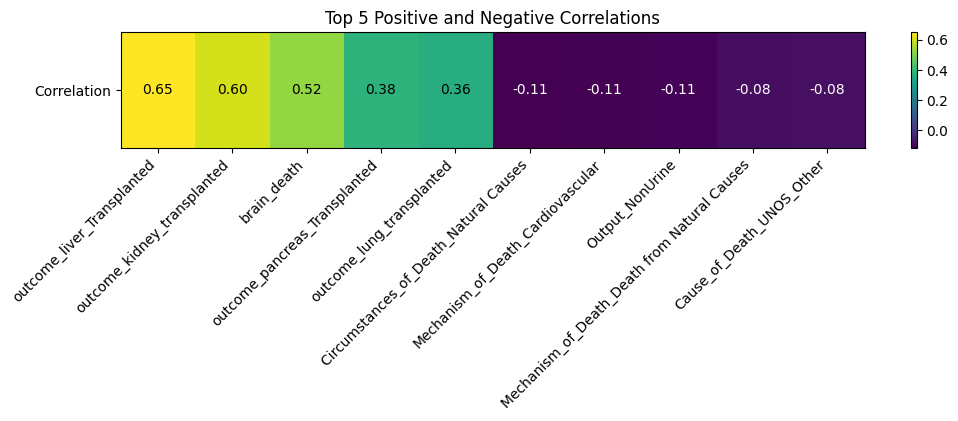

In [33]:

# Manually assemble top 5 positive and top 5 negative correlations
data = {
    'variable': [
        'outcome_liver_Transplanted',
        'outcome_kidney_transplanted',
        'brain_death',
        'outcome_pancreas_Transplanted',
        'outcome_lung_transplanted',
        'Circumstances_of_Death_Natural Causes',
        'Mechanism_of_Death_Cardiovascular',
        'Output_NonUrine',
        'Mechanism_of_Death_Death from Natural Causes',
        'Cause_of_Death_UNOS_Other'
    ],
    'correlation': [
        0.648482,
        0.600021,
        0.524506,
        0.380509,
        0.361932,
        -0.113322,
        -0.108332,
        -0.105741,
        -0.083857,
        -0.081788
    ]
}

df = pd.DataFrame(data)

# Prepare heatmap data: single row, variables as columns
heat = df['correlation'].values.reshape(1, -1)
labels = df['variable'].tolist()

fig, ax = plt.subplots(figsize=(12, 1.5))
im = ax.imshow(heat, aspect='auto', cmap='viridis')

# Annotate each cell with the correlation value
for idx, val in enumerate(df['correlation']):
    color = 'black' if val > 0 else 'white'
    ax.text(idx, 0, f"{val:.2f}", ha='center', va='center', color=color)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks([0])
ax.set_yticklabels(['Correlation'])

# Add colorbar
fig.colorbar(im, ax=ax)

ax.set_title('Top 5 Positive and Negative Correlations')
plt.tight_layout()
plt.show()



C:\Users\chris\AppData\Local\Temp\ipykernel_4796\1702068944.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


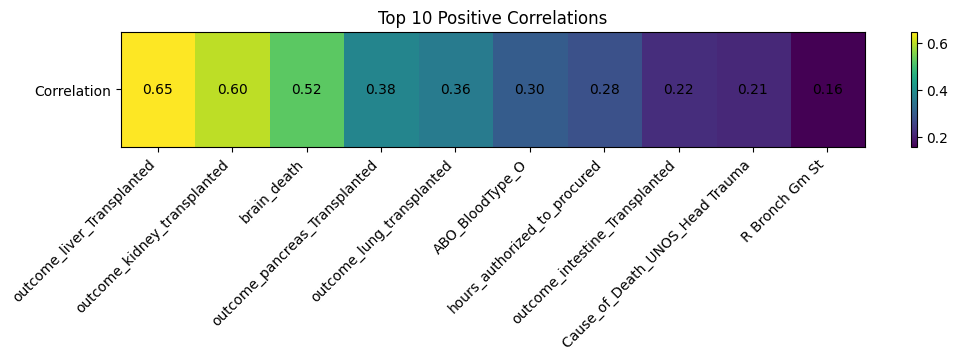

In [34]:
# Select top 10 positive correlations
top10 = corr_df.nlargest(10, 'correlation').reset_index()

# Prepare heatmap data: single row, variables as columns
heat = top10['correlation'].values.reshape(1, -1)
labels = top10['variable'].tolist()

fig, ax = plt.subplots(figsize=(12, 1.5))
im = ax.imshow(heat, aspect='auto', cmap='viridis')

# Annotate each cell with the correlation value
for idx, val in enumerate(top10['correlation']):
    color = 'black'
    ax.text(idx, 0, f"{val:.2f}", ha='center', va='center', color=color)

# Set axis ticks and labels
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks([0])
ax.set_yticklabels(['Correlation'])

# Add colorbar
fig.colorbar(im, ax=ax)

ax.set_title('Top 10 Positive Correlations')
plt.tight_layout()

plt.show()

In [62]:
exclude = [
    'outcome_liver_Transplanted',
    'outcome_kidney_transplanted',
    'outcome_pancreas_Transplanted',
    'outcome_lung_transplanted',
    'outcome_intestine_Transplanted'
]

top20 = corr_df.loc[~corr_df['variable'].isin(exclude)].head(20)
display(top20)



,variable,correlation,p_value,method
2,brain_death,0.524506,4.479820e-96,point-biserial
208,ABO_BloodType_O,0.299531,2.531135e-29,point-biserial
223,hours_authorized_to_procured,0.277662,2.870087e-25,point-biserial
160,Cause_of_Death_UNOS_Head Trauma,0.212028,3.717796e-15,point-biserial
16,R Bronch Gm St,0.156163,3.460056e-05,point-biserial
170,Mechanism_of_Death_Blunt Injury,0.146991,5.984987e-08,point-biserial
202,ABO_BloodType_A1,0.131832,1.202946e-06,point-biserial
194,Circumstances_of_Death_MVA,0.115063,2.304683e-05,point-biserial
196,Circumstances_of_Death_Natural Causes,-0.113322,3.064041e-05,point-biserial
191,Circumstances_of_Death_Child Abuse,0.110266,5.001572e-05,point-biserial


In [70]:

# Copy & split
df = peds_heart.copy()
grp = df['outcome_heart_Transplanted']
df_yes = df[grp == 1]
df_no  = df[grp == 0]

# Identify var types—include bools as categorical, exclude them from continuous
categorical_cols = [
    c for c in df.columns 
    if (
         df[c].dtype.name in ('object','category')
      or pd.api.types.is_bool_dtype(df[c])
    )
]
continuous_cols = [
    c for c in df.columns
    if (
         pd.api.types.is_numeric_dtype(df[c])       # numeric
      and not pd.api.types.is_bool_dtype(df[c])     # not bool
      and c != 'outcome_heart_Transplanted'          # skip the target
    )
]

# Build summaries
rows = []

# categoricals
for col in categorical_cols:
    # cross‑tab counts
    ct = pd.crosstab(df[col], grp)
    pct = ct.div(ct.sum(axis=1), axis=0) * 100
    
    # choose χ² or Fisher
    if (ct.values < 5).any():
        # Fisher’s exact only for 2×2
        if ct.shape == (2,2):
            p = fisher_exact(ct.values)[1]
        else:
            p = np.nan
    else:
        p = chi2_contingency(ct.values)[1]
    
    for lvl in ct.index:
        rows.append({
            'variable': col,
            'level'   : str(lvl),
            'group=0_count': int(ct.loc[lvl,0]),
            'group=0_pct'  : pct.loc[lvl,0],
            'group=1_count': int(ct.loc[lvl,1]),
            'group=1_pct'  : pct.loc[lvl,1],
            'metric'       : 'n (%)',
            'p_value'      : p
        })

# continuous
for col in continuous_cols:
    a = df_no[col].dropna()
    b = df_yes[col].dropna()
    # descriptive stats
    stats = {
      'group=0_mean': a.mean(),
      'group=0_q1'  : a.quantile(0.25),
      'group=0_q3'  : a.quantile(0.75),
      'group=0_iqr' : a.quantile(0.75) - a.quantile(0.25),
      'group=0_sd'  : a.std(ddof=1),
      'group=1_mean': b.mean(),
      'group=1_q1'  : b.quantile(0.25),
      'group=1_q3'  : b.quantile(0.75),
      'group=1_iqr' : b.quantile(0.75) - b.quantile(0.25),
      'group=1_sd'  : b.std(ddof=1),
    }
    # two‑sample t‑test
    t_p = ttest_ind(a, b, nan_policy='omit', equal_var=False).pvalue
    row = {
      'variable': col,
      'level'   : '',
      'metric'  : 'mean (Q1, Q3, IQR, SD)',
      'p_value' : t_p,
      **stats
    }
    rows.append(row)

# assemble
summary_df = pd.DataFrame(rows)

# display
from IPython.display import display
display(summary_df)

C:\Users\chris\anaconda3\envs\orchid\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,variable,level,group=0_count,group=0_pct,group=1_count,group=1_pct,metric,p_value,group=0_mean,group=0_q1,group=0_q3,group=0_iqr,group=0_sd,group=1_mean,group=1_q1,group=1_q3,group=1_iqr,group=1_sd
0,OPO_OPO1,False,655.0,68.802521,297.0,31.197479,n (%),7.053722e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OPO_OPO1,True,251.0,63.544304,144.0,36.455696,n (%),7.053722e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OPO_OPO2,False,831.0,68.620974,380.0,31.379026,n (%),2.079885e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OPO_OPO2,True,75.0,55.147059,61.0,44.852941,n (%),2.079885e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OPO_OPO3,False,848.0,67.355044,411.0,32.644956,n (%),8.713314e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,hours_referred_to_approached,,NaN,NaN,NaN,NaN,"mean (Q1, Q3, IQR, SD)",1.045722e-02,0.294687,0.162230,0.433326,0.271096,0.222900,0.329858,0.162230,0.491833,0.329603,0.242169
235,hours_approached_to_authorized,,NaN,NaN,NaN,NaN,"mean (Q1, Q3, IQR, SD)",7.483644e-01,0.114048,0.003333,0.150000,0.146667,0.149406,0.117873,0.000000,0.068794,0.068794,0.227513
236,hours_authorized_to_procured,,NaN,NaN,NaN,NaN,"mean (Q1, Q3, IQR, SD)",6.343430e-20,0.193711,0.057892,0.283333,0.225441,0.179902,0.321337,0.083333,0.500000,0.416667,0.254709
237,outcome_kidney_transplanted,,NaN,NaN,NaN,NaN,"mean (Q1, Q3, IQR, SD)",7.690635e-165,0.274834,0.000000,1.000000,1.000000,0.446677,0.913832,1.000000,1.000000,0.000000,0.280930


In [82]:

# Copy & drop single‐value cols
df = peds_heart.copy()
single_val = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
df.drop(columns=single_val, inplace=True)

# Split into groups
grp     = df['outcome_heart_Transplanted']
df_yes  = df[grp == 1]
df_no   = df[grp == 0]

# Force OPO flags to categorical (optional but recommended)
opo_cols = [c for c in df.columns if c.startswith("OPO_OPO")]
df[opo_cols] = df[opo_cols].astype("category")

# Auto–detect var types
categorical_cols = [
    c for c in df.columns
    if (
         pd.api.types.is_categorical_dtype(df[c])
      or pd.api.types.is_object_dtype(df[c])
      or df[c].nunique() == 2
    )
]
continuous_cols = [
    c for c in df.columns
    if (
         pd.api.types.is_numeric_dtype(df[c])
      and c not in categorical_cols
      and c != 'outcome_heart_Transplanted'
    )
]

# Build summary rows
rows = []

# Categoricals: counts, % & χ²/Fisher p‑value
for col in categorical_cols:
    ct  = pd.crosstab(df[col], grp)
    pct = ct.div(ct.sum(axis=1), axis=0) * 100

    # choose χ² vs Fisher
    if (ct.values < 5).any() and ct.shape == (2,2):
        p = fisher_exact(ct.values)[1]
    else:
        p = chi2_contingency(ct.values)[1]

    for lvl in ct.index:
        rows.append({
            'variable'      : col,
            'level'         : lvl,
            'group=0_count' : int(ct.loc[lvl,0]),
            'group=0_pct'   : pct.loc[lvl,0],
            'group=1_count' : int(ct.loc[lvl,1]),
            'group=1_pct'   : pct.loc[lvl,1],
            'metric'        : 'n (%)',
            'p_value'       : p
        })

# Continuous: mean, Q1, Q3, IQR, SD & t‑test p‑value
for col in continuous_cols:
    a = df_no[col].dropna()
    b = df_yes[col].dropna()
    stats = {
        'group=0_mean': a.mean(),
        'group=0_q1'  : a.quantile(0.25),
        'group=0_q3'  : a.quantile(0.75),
        'group=0_iqr' : a.quantile(0.75) - a.quantile(0.25),
        'group=0_sd'  : a.std(ddof=1),
        'group=1_mean': b.mean(),
        'group=1_q1'  : b.quantile(0.25),
        'group=1_q3'  : b.quantile(0.75),
        'group=1_iqr' : b.quantile(0.75) - b.quantile(0.25),
        'group=1_sd'  : b.std(ddof=1),
    }
    pval = ttest_ind(a, b, nan_policy='omit', equal_var=False).pvalue
    rows.append({
        'variable': col,
        'level'   : '',
        'metric'  : 'mean (Q1, Q3, IQR, SD)',
        'p_value' : pval,
        **stats
    })

# Assemble & display
summary_df = pd.DataFrame(rows)
from IPython.display import display
display(summary_df)

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\2278954526.py:19: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  pd.api.types.is_categorical_dtype(df[c])


,variable,level,group=0_count,group=0_pct,group=1_count,group=1_pct,metric,p_value,group=0_mean,group=0_q1,group=0_q3,group=0_iqr,group=0_sd,group=1_mean,group=1_q1,group=1_q3,group=1_iqr,group=1_sd
0,Gender,0.0,372.0,69.924812,160.0,30.075188,n (%),1.043487e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gender,1.0,534.0,65.521472,281.0,34.478528,n (%),1.043487e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,brain_death,0,495.0,99.397590,3.0,0.602410,n (%),1.070760e-107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,brain_death,1,411.0,48.409894,438.0,51.590106,n (%),1.070760e-107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,transplanted,0,643.0,100.000000,0.0,0.000000,n (%),2.059429e-168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,hours_asystole_to_referred,,NaN,NaN,NaN,NaN,"mean (Q1, Q3, IQR, SD)",1.915546e-01,0.243606,0.030851,0.391688,0.360837,0.221067,0.229038,0.054917,0.370000,0.315083,0.176102
390,hours_brain_death_to_referred,,NaN,NaN,NaN,NaN,"mean (Q1, Q3, IQR, SD)",3.023737e-03,0.249065,0.036229,0.395326,0.359098,0.212023,0.290349,0.064083,0.457083,0.393000,0.251084
391,hours_referred_to_approached,,NaN,NaN,NaN,NaN,"mean (Q1, Q3, IQR, SD)",1.045722e-02,0.294687,0.162230,0.433326,0.271096,0.222900,0.329858,0.162230,0.491833,0.329603,0.242169
392,hours_approached_to_authorized,,NaN,NaN,NaN,NaN,"mean (Q1, Q3, IQR, SD)",7.483644e-01,0.114048,0.003333,0.150000,0.146667,0.149406,0.117873,0.000000,0.068794,0.068794,0.227513


Across the heart‐donor referrals in this cohort, several binary referral‐and‐testing flags differ markedly between recipients who ultimately underwent transplantation (group 1) versus those who did not (group 0). Notably, brain death status shows a dramatic shift: almost all non‑transplanted donors were not brain‑dead (99.4 % vs. 0.6 %), whereas over half of transplanted donors were (51.6 % vs. 48.4 %), p < 1 × 10⁻¹⁰⁷. Referral type also matters: tissue and eye referrals were both more common among transplanted donors (tissue 34.9 % vs. 22.6 %, p = 3 × 10⁻⁴; eye 35.4 % vs. 22.7 %, p = 8 × 10⁻⁵), suggesting that centers with multi‑tissue interests may more aggressively pursue hearts. Several microbiology flags (e.g. positive Gram‑stains of the right and left bronchi, sputum) were also significantly more frequent in transplanted cases (for example, R Bronch Gm St: 73 % vs. 50 %, p = 6 × 10⁻⁵), which may reflect more intensive peri‑donation evaluation rather than a barrier to procurement.

On the continuous side, Age of the donor differed only slightly (mean 7.7 years non‑transplanted vs. 8.7 years transplanted, p ≈ 0.005), while Height and Weight were modestly higher in transplanted donors (Height 48.4 in vs. 50.95 in, p ≈ 0.03; Weight 34.8 kg vs. 41.5 kg, p ≈ 1 × 10⁻⁴). Timing intervals from brain death or asystole to referral, approach, authorization, and procurement showed no consistent directional differences (all p > 0.05), indicating that logistical delays were similar regardless of ultimate transplant status. Overall, the strongest discriminators of transplantation were clinical donor characteristics (especially brain‑death status) and the engagement of multiple referral streams, rather than differences in donor size or process timing.

In [95]:
import warnings
import scipy.stats as stats

# suppress only the “DegenerateDataWarning” from f_oneway
warnings.filterwarnings("ignore",
                        category=stats.DegenerateDataWarning)
# Copy & drop single‑value cols (as before)
df = peds_heart.copy()
single_val = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
df.drop(columns=single_val, inplace=True)

# Melt the OPO one‑hots into a single “OPO” label
opo_cols = [c for c in df.columns if c.startswith("OPO_OPO")]
df['OPO'] = (
    df[opo_cols]
      .idxmax(axis=1)                  # e.g. 'OPO_OPO3'
      .str.replace('OPO_OPO', '')      # → '3'
      .astype(int)
)
df.drop(columns=opo_cols, inplace=True)

# Identify var types again
cat_cols = [c for c in df.columns
            if df[c].dtype.name in ('object','category')
            or df[c].nunique() == 2
            or c == 'OPO']
cont_cols = [c for c in df.columns
             if pd.api.types.is_numeric_dtype(df[c])
             and c not in cat_cols]

# Continuous: group‑wise descriptive + ANOVA p‑value
cont_summary = []
for col in cont_cols:
    stats = df.groupby('OPO')[col].agg([
        ('mean','mean'),
        ('q1',   lambda x: x.quantile(0.25)),
        ('q3',   lambda x: x.quantile(0.75)),
        ('iqr',  lambda x: x.quantile(0.75) - x.quantile(0.25)),
        ('sd',   'std'),
    ]).reset_index()
    # ANOVA across OPO groups
    groups = [grp[col].dropna() for _,grp in df.groupby('OPO')]
    p = f_oneway(*groups).pvalue if len(groups) > 1 else np.nan

    stats['p_value'] = p
    stats['variable'] = col
    cont_summary.append(stats)

cont_summary_df = pd.concat(cont_summary, ignore_index=True)

# Categoricals: count & % by OPO + χ² p‐value
cat_summary = []
for col in cat_cols:
    ct = pd.crosstab(df[col], df['OPO'])
    pct = ct.div(ct.sum(axis=0), axis=1)*100

    # χ² test (omit Fisher for >2×2)
    try:
        p = chi2_contingency(ct.values)[1]
    except:
        p = np.nan

    for lvl in ct.index:
        row = {
            'variable': col,
            'level': lvl,
            'p_value': p
        }
        for opo in ct.columns:
            row[f'OPO{opo}_count'] = ct.loc[lvl,opo]
            row[f'OPO{opo}_pct']   = pct.loc[lvl,opo]
        cat_summary.append(row)

cat_summary_df = pd.DataFrame(cat_summary)

# Display results
from IPython.display import display
print("=== Continuous variables by OPO ===")
display(cont_summary_df)

print("=== Categorical variables by OPO ===")
display(cat_summary_df)


=== Continuous variables by OPO ===


,OPO,mean,q1,q3,iqr,sd,p_value,variable
0,1,8.007595,1.000000,15.000000,14.000000,6.487977,1.022964e-01,Age
1,2,9.411765,3.000000,15.000000,12.000000,6.064433,1.022964e-01,Age
2,3,8.147727,1.000000,15.000000,14.000000,6.653216,1.022964e-01,Age
3,4,7.996667,1.000000,15.000000,14.000000,6.592028,1.022964e-01,Age
4,5,7.815385,1.000000,14.000000,13.000000,6.515541,1.022964e-01,Age
...,...,...,...,...,...,...,...,...
439,2,0.329926,0.139167,0.483333,0.344167,0.226979,7.498417e-54,hours_authorized_to_procured
440,3,0.287538,0.110000,0.437500,0.327500,0.230598,7.498417e-54,hours_authorized_to_procured
441,4,0.284856,0.120000,0.433333,0.313333,0.211000,7.498417e-54,hours_authorized_to_procured
442,5,0.057892,0.057892,0.057892,0.000000,0.000000,7.498417e-54,hours_authorized_to_procured


=== Categorical variables by OPO ===


,variable,level,p_value,OPO1_count,OPO1_pct,OPO2_count,OPO2_pct,OPO3_count,OPO3_pct,OPO4_count,OPO4_pct,OPO5_count,OPO5_pct,OPO6_count,OPO6_pct
0,Gender,0.0,9.708570e-02,171,43.291139,45,33.088235,36,40.909091,109,36.333333,95.0,36.538462,76,45.238095
1,Gender,1.0,9.708570e-02,224,56.708861,91,66.911765,52,59.090909,191,63.666667,165.0,63.461538,92,54.761905
2,brain_death,0.0,8.381818e-12,132,33.417722,25,18.382353,26,29.545455,132,44.000000,135.0,51.923077,48,28.571429
3,brain_death,1.0,8.381818e-12,263,66.582278,111,81.617647,62,70.454545,168,56.000000,125.0,48.076923,120,71.428571
4,transplanted,0.0,3.874782e-03,173,43.797468,53,38.970588,40,45.454545,171,57.000000,123.0,47.307692,83,49.404762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,OPO,2.0,0.000000e+00,0,0.000000,136,100.000000,0,0.000000,0,0.000000,0.0,0.000000,0,0.000000
310,OPO,3.0,0.000000e+00,0,0.000000,0,0.000000,88,100.000000,0,0.000000,0.0,0.000000,0,0.000000
311,OPO,4.0,0.000000e+00,0,0.000000,0,0.000000,0,0.000000,300,100.000000,0.0,0.000000,0,0.000000
312,OPO,5.0,0.000000e+00,0,0.000000,0,0.000000,0,0.000000,0,0.000000,260.0,100.000000,0,0.000000


Overall, donor demographics are remarkably consistent across the six OPO regions: average age ranges only from about 7.2 years (OPO 6) up to 9.4 years (OPO 2), and these differences do not reach statistical significance (ANOVA p ≈ 0.10). Likewise, donor height (≈47–52 inches, p ≈ 0.52) and weight (≈33–43 kg, p ≈ 0.075) show only modest regional variation. In contrast, the calendar timing of referrals and procurements differs highly significantly by OPO (p < 1 × 10⁻¹⁹): for example, OPO 2’s referrals occur on average in late 2019, whereas OPO 1 centers were most active in 2017–18. 

Process‑related measures—especially cumulative intake and output volumes and the timing intervals from asystole or brain‑death through approach, authorization, and procurement—all vary significantly by OPO (p’s ranging from <10⁻⁵⁴ to <10⁻⁷⁹). For instance, OPO 3 donors received higher crystalloid volumes (mean ≈13,110 mL) compared with OPO 2 (≈9,400 mL) or OPO 6 (≈11,170 mL), and the lag from authorization to procurement peaks in OPO 2 (~0.33 h) versus lows of ~0.06 h in OPO 5 (where only a few cases exist). These procedural disparities underline the importance of regional practice patterns in donor management even when donor characteristics themselves are broadly similar.

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\2480078330.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,


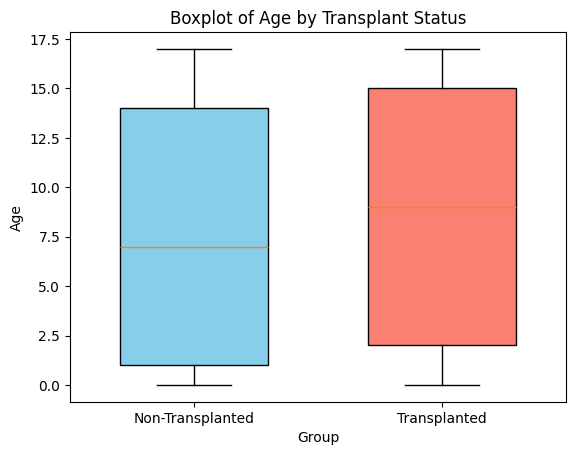

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\2480078330.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,


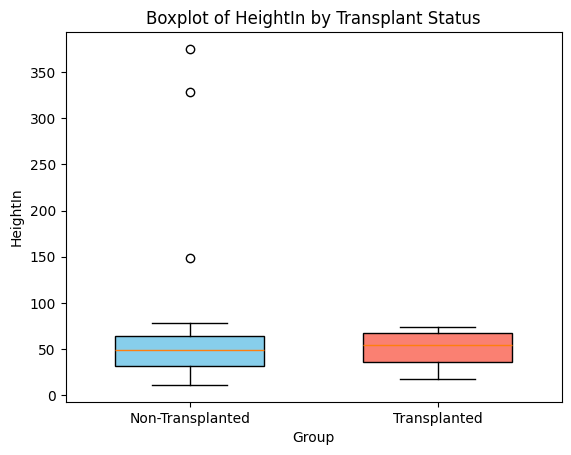

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\2480078330.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data,


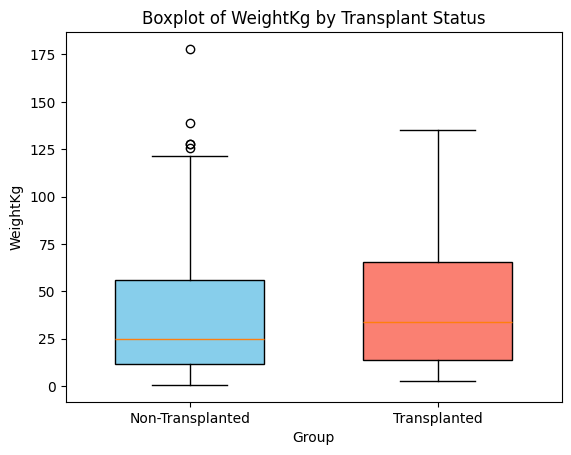

In [105]:

# Prepare DataFrame 
df_vis = peds_heart.copy()
df_vis['group'] = df_vis['outcome_heart_Transplanted'].map({
    0: 'Non-Transplanted', 1: 'Transplanted'
})

# Features to plot
sign_cont = ['Age', 'HeightIn', 'WeightKg']

# Define colors for each group
colors = {
    'Non-Transplanted': 'skyblue',
    'Transplanted': 'salmon'
}

for col in sign_cont:
    # Gather data
    data = [
        df_vis[df_vis['group'] == grp][col].dropna()
        for grp in ['Non-Transplanted', 'Transplanted']
    ]
    
    # Boxplot with colors
    fig, ax = plt.subplots()
    bp = ax.boxplot(data,
                    labels=['Non-Transplanted', 'Transplanted'],
                    patch_artist=True,
                    widths=0.6)
    for patch, grp in zip(bp['boxes'], ['Non-Transplanted', 'Transplanted']):
        patch.set_facecolor(colors[grp])
    
    ax.set_title(f'Boxplot of {col} by Transplant Status')
    ax.set_xlabel('Group')
    ax.set_ylabel(col)
    plt.show()


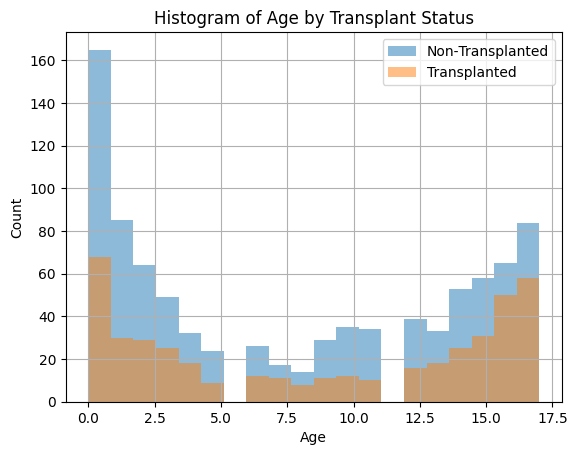

<Figure size 640x480 with 0 Axes>

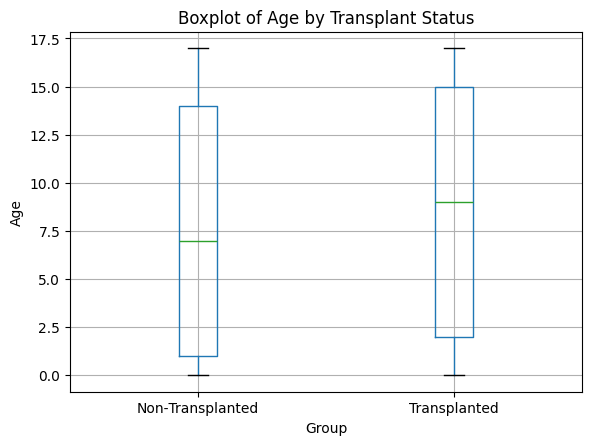

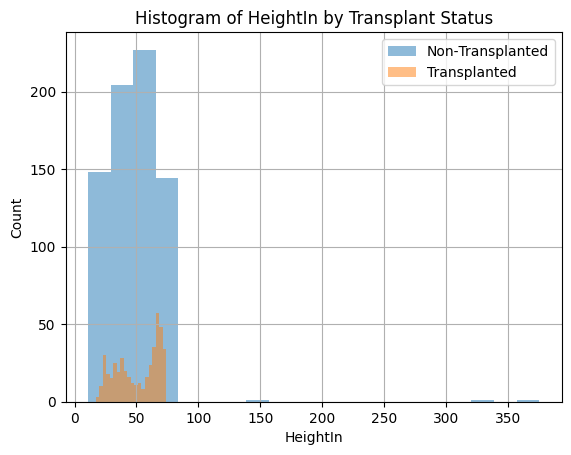

<Figure size 640x480 with 0 Axes>

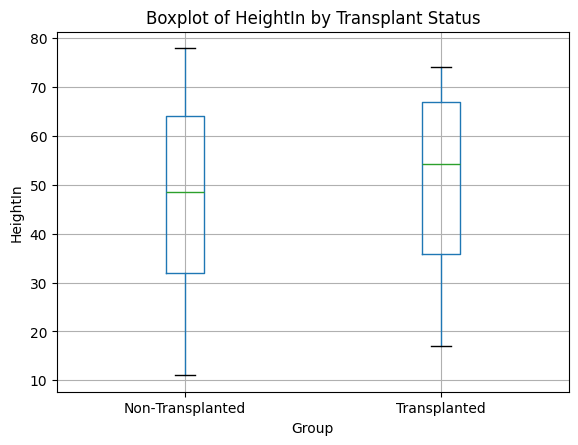

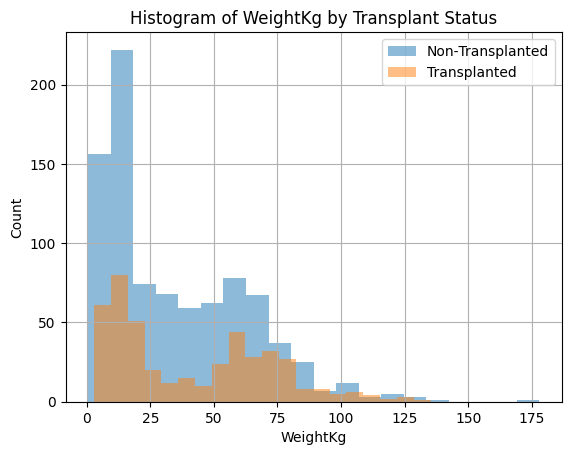

<Figure size 640x480 with 0 Axes>

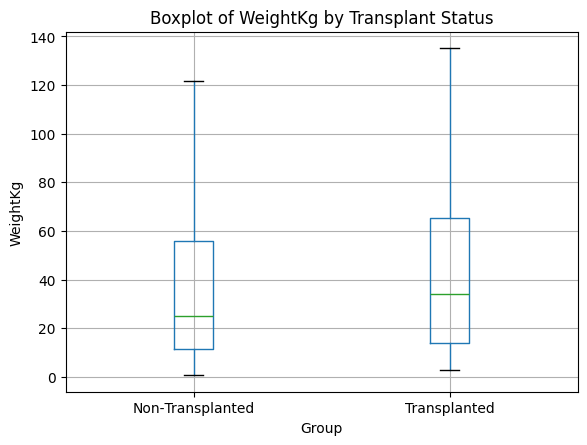

In [107]:

# create a copy and label groups
df_vis = peds_heart.copy()
df_vis['group'] = df_vis['outcome_heart_Transplanted'].map({
    0: 'Non‑Transplanted', 1: 'Transplanted'
})

# features with p ≤ 0.05 from your earlier tests
sign_cont = ['Age', 'HeightIn', 'WeightKg']

for col in sign_cont:
    # Histogram
    plt.figure()
    df_vis[df_vis['group']=='Non‑Transplanted'][col] \
        .hist(bins=20, alpha=0.5, label='Non‑Transplanted')
    df_vis[df_vis['group']=='Transplanted'][col] \
        .hist(bins=20, alpha=0.5, label='Transplanted')
    plt.title(f'Histogram of {col} by Transplant Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Boxplot with 1.5×IQR whiskers (outliers hidden)
    plt.figure()
    df_vis.boxplot(column=col, by='group', showfliers=False)
    plt.title(f'Boxplot of {col} by Transplant Status')
    plt.suptitle('')
    plt.xlabel('Group')
    plt.ylabel(col)
    plt.show()


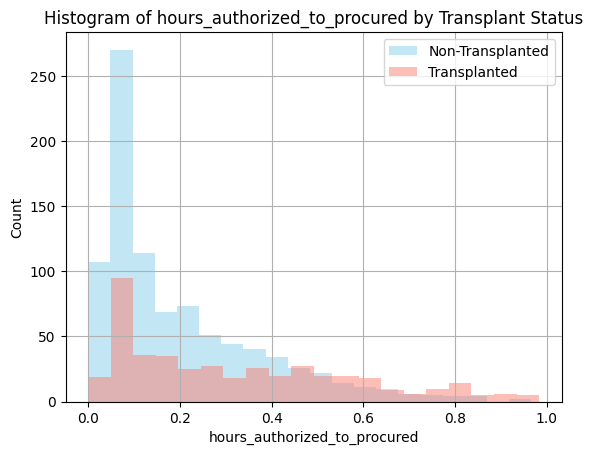

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\324311439.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


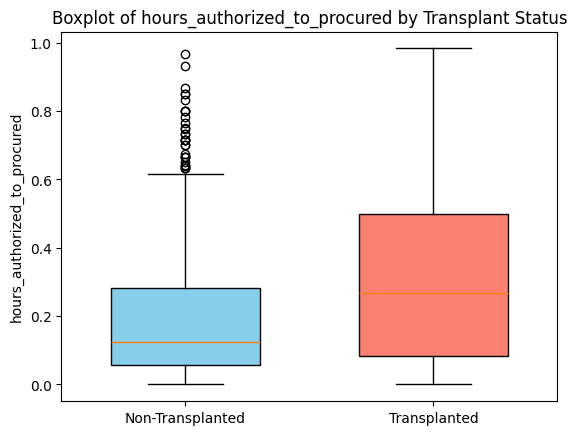

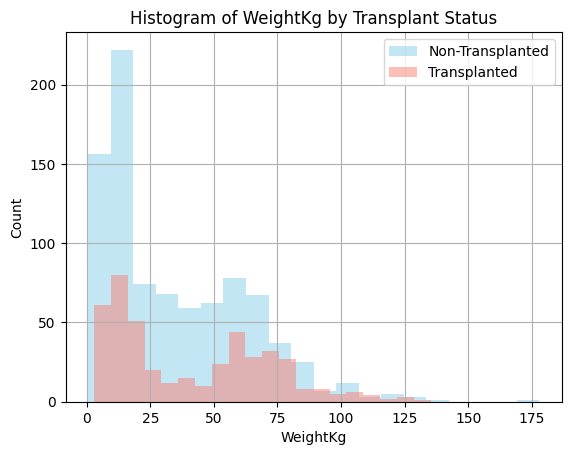

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\324311439.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


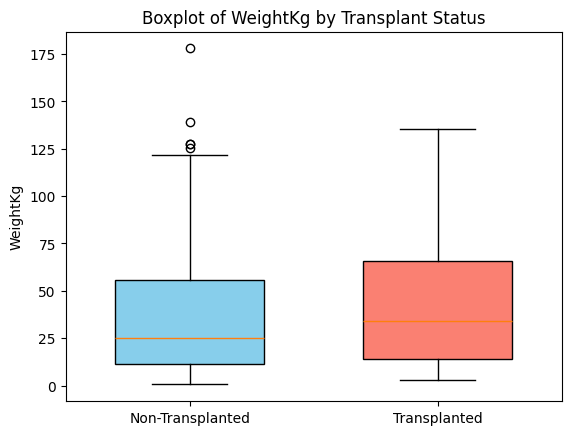

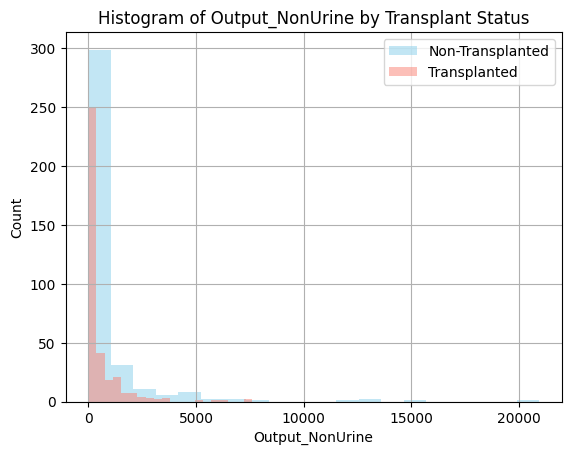

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\324311439.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


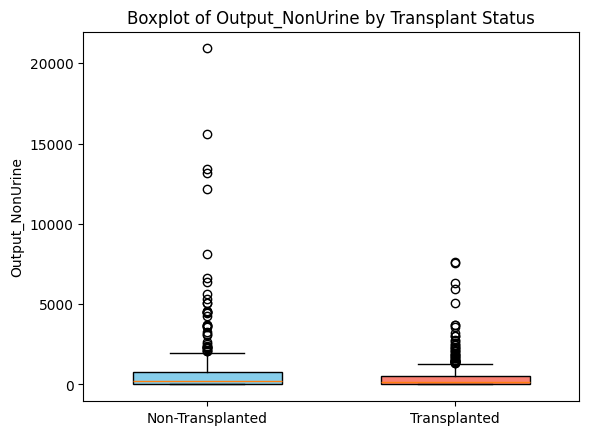

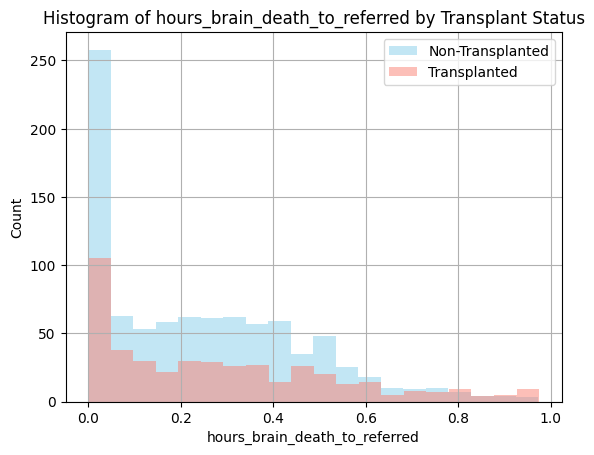

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\324311439.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


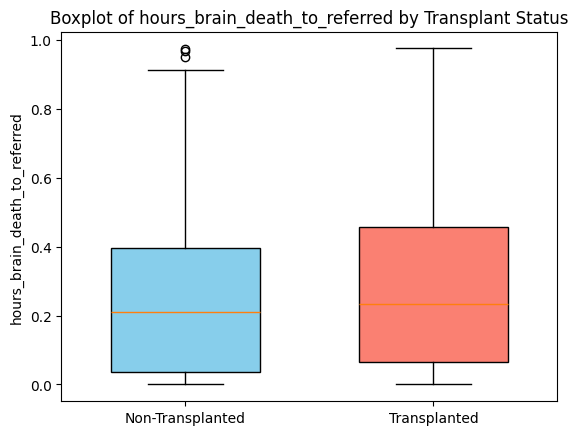

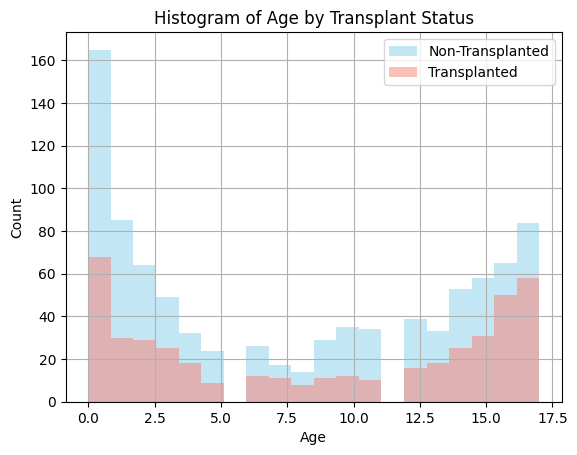

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\324311439.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


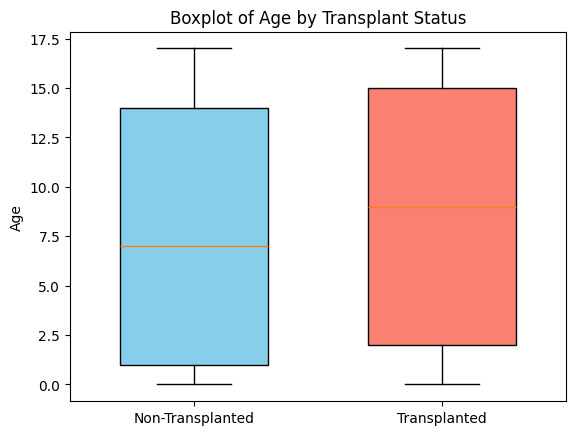

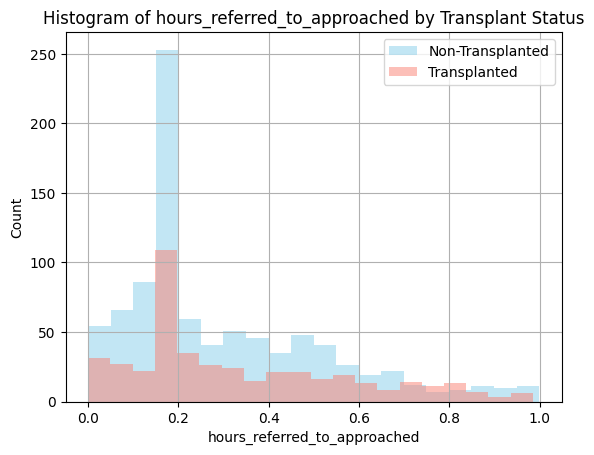

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\324311439.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


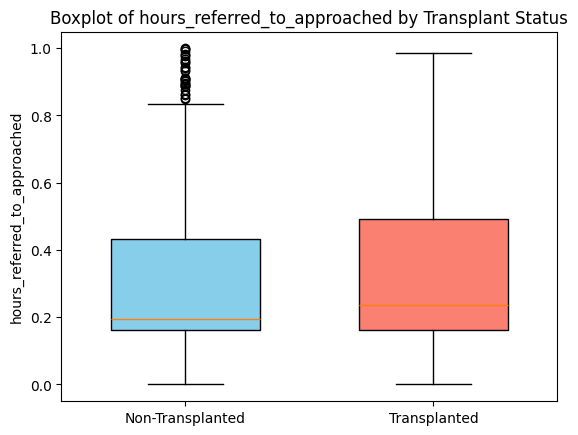

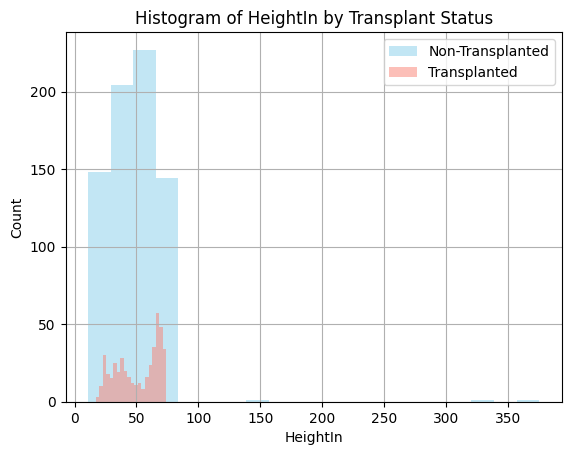

C:\Users\chris\AppData\Local\Temp\ipykernel_4796\324311439.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


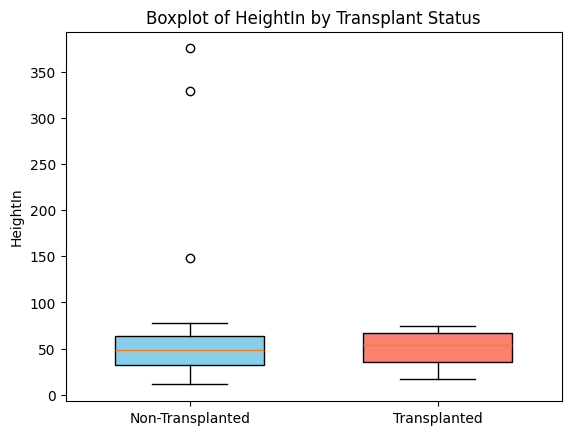

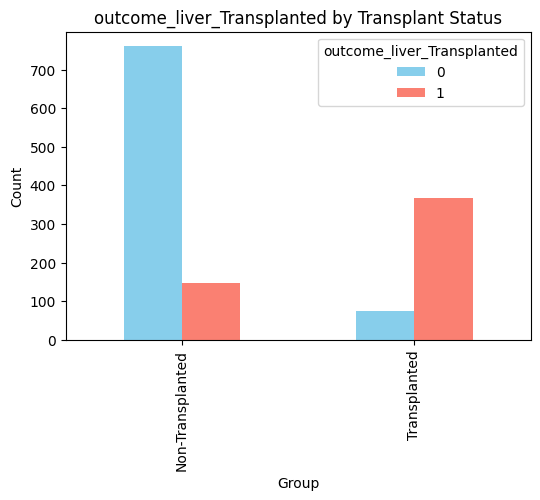

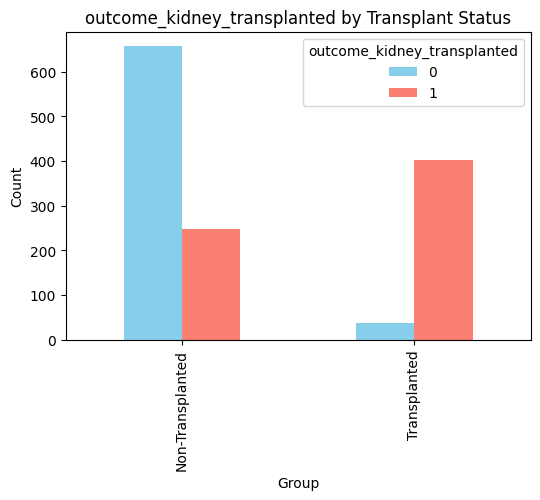

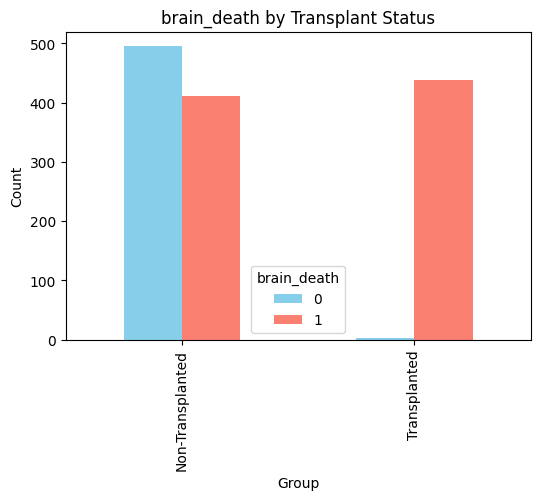

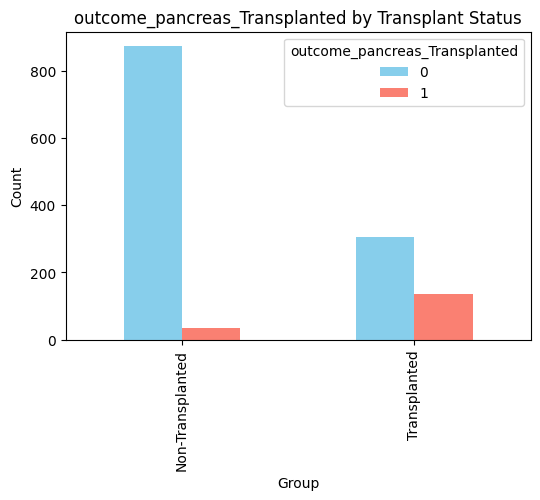

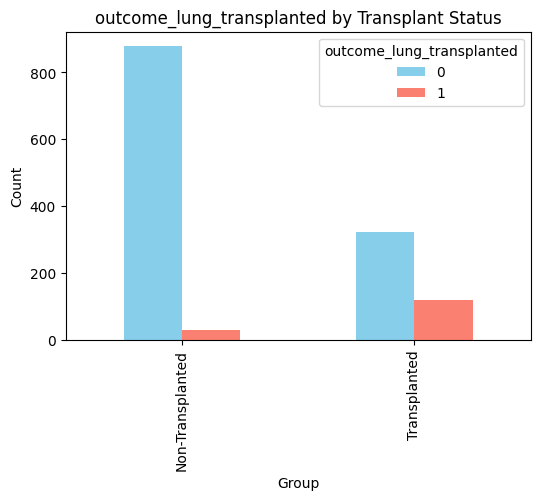

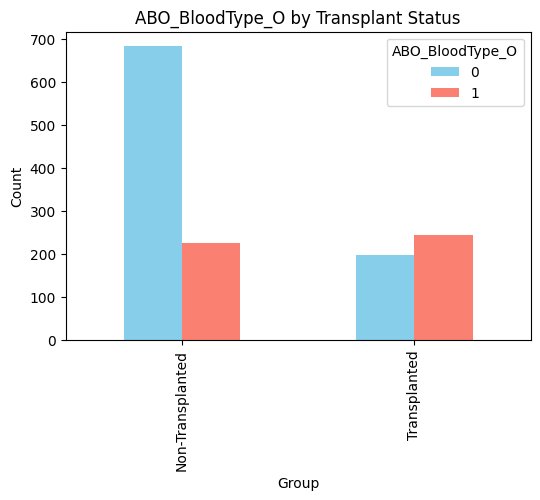

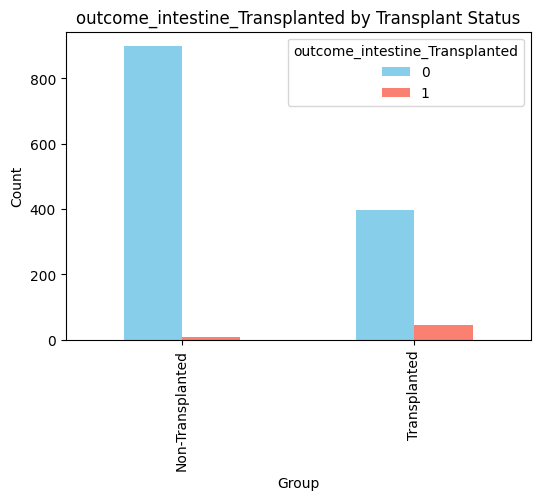

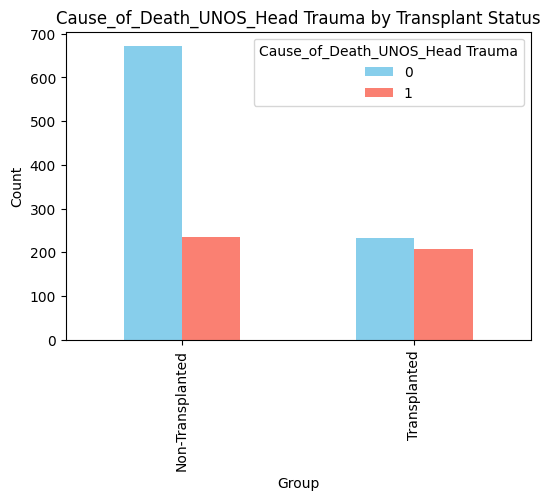

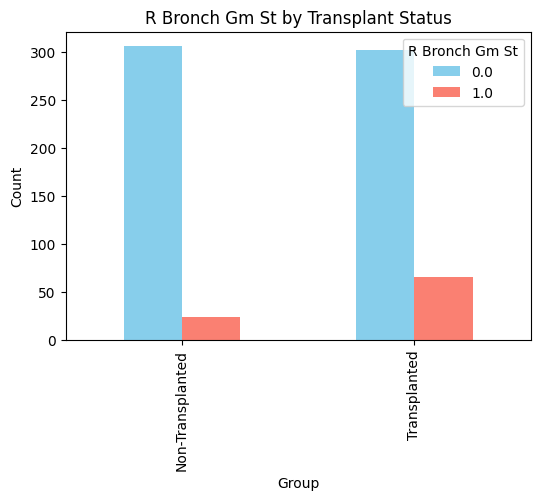

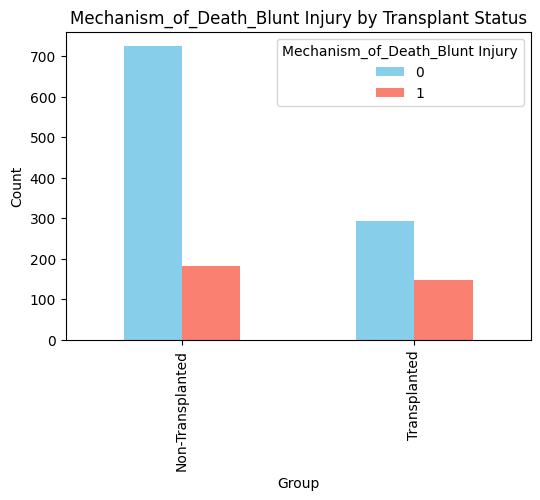

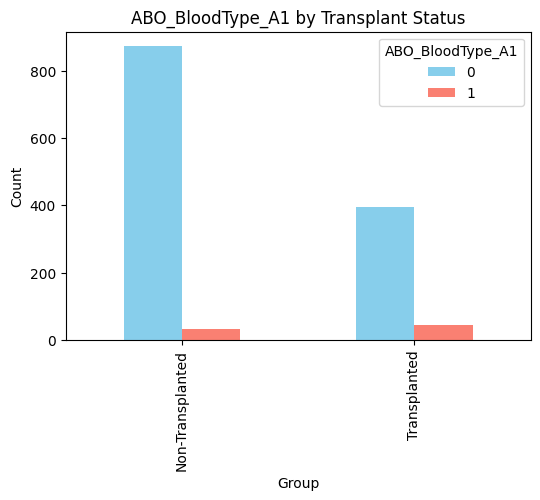

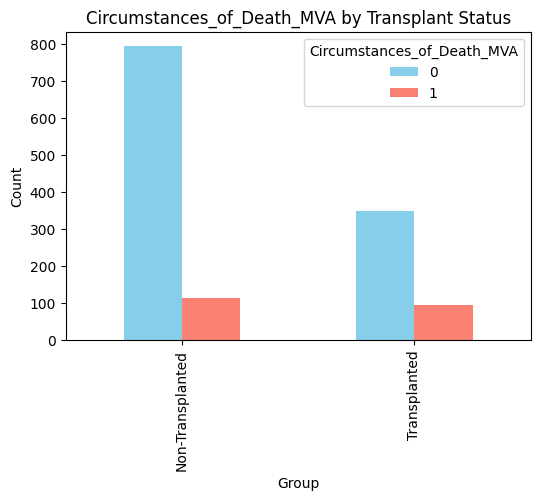

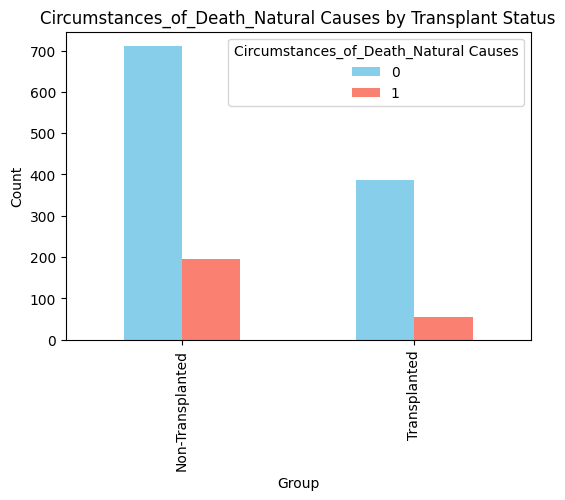

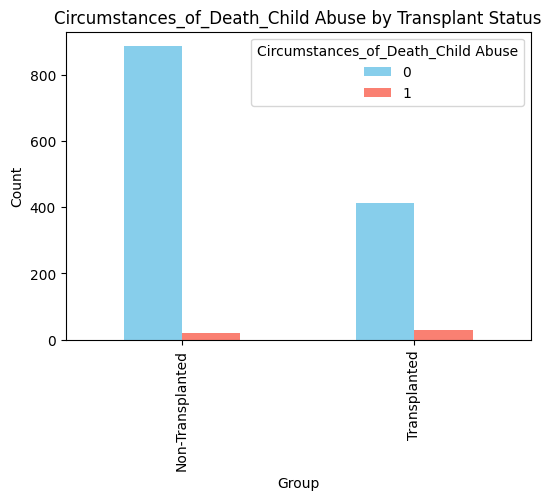

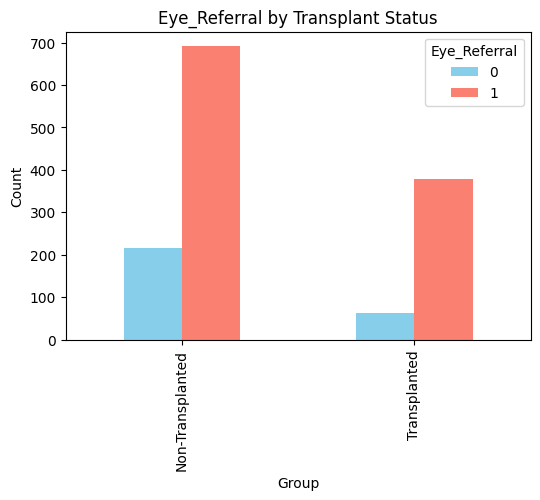

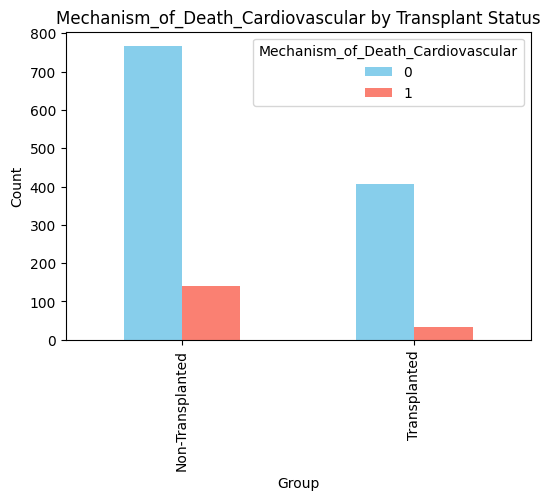

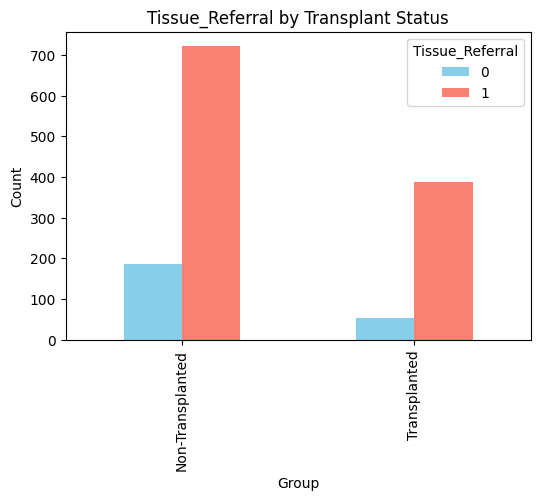

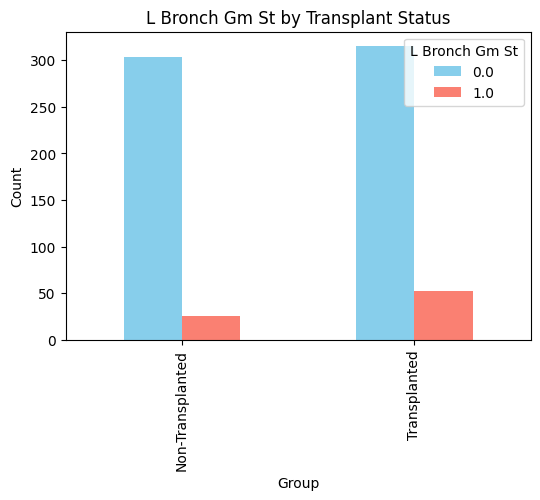

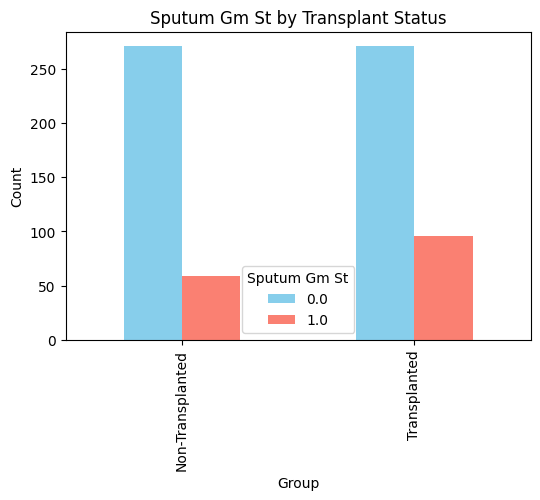

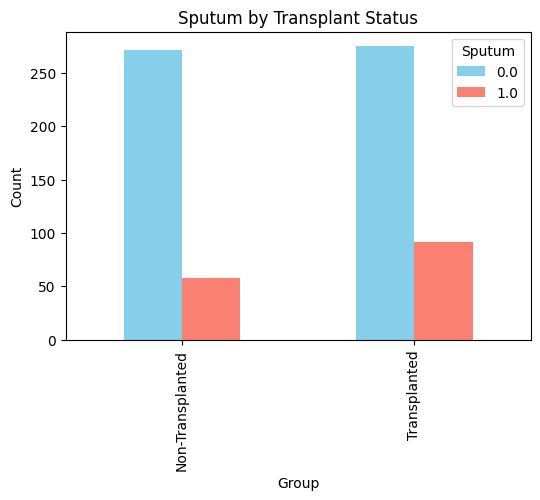

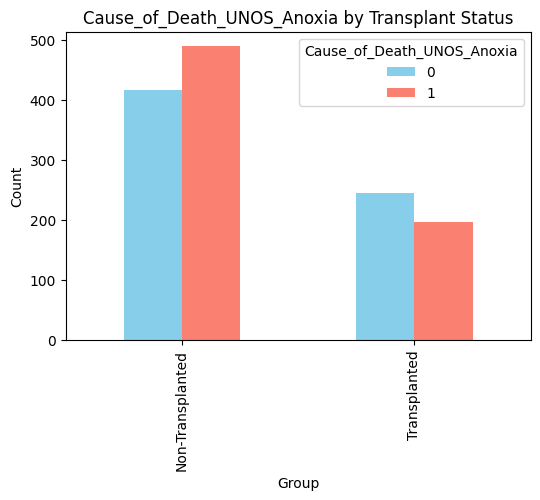

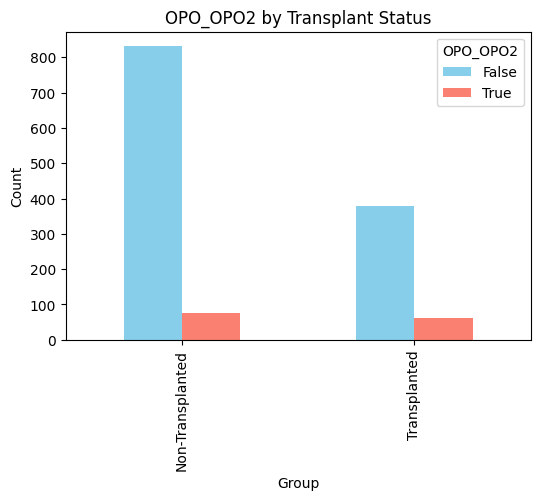

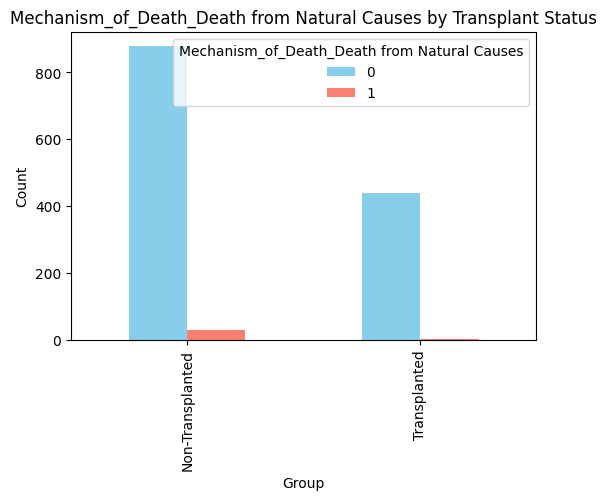

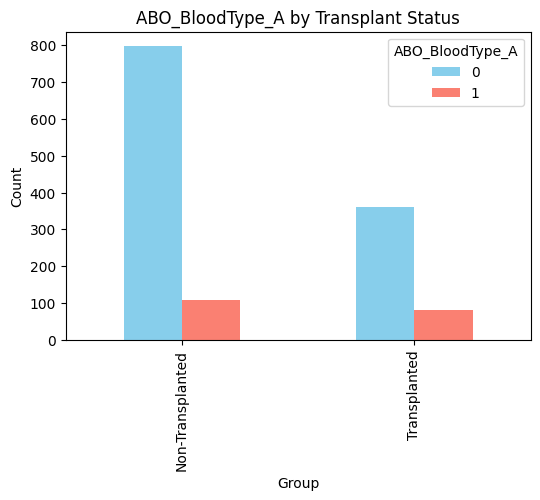

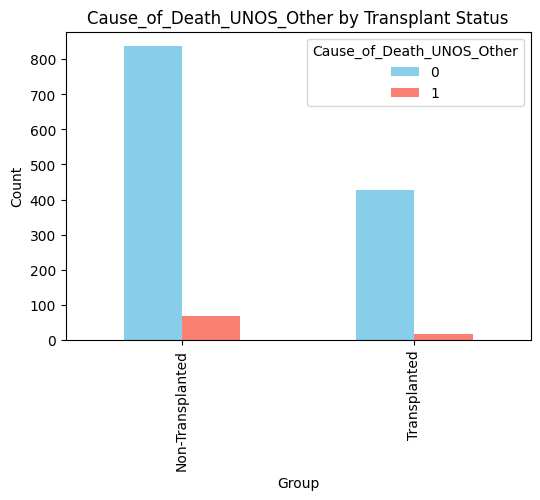

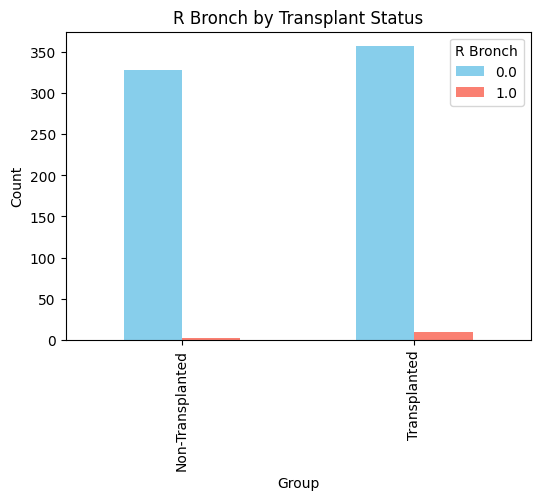

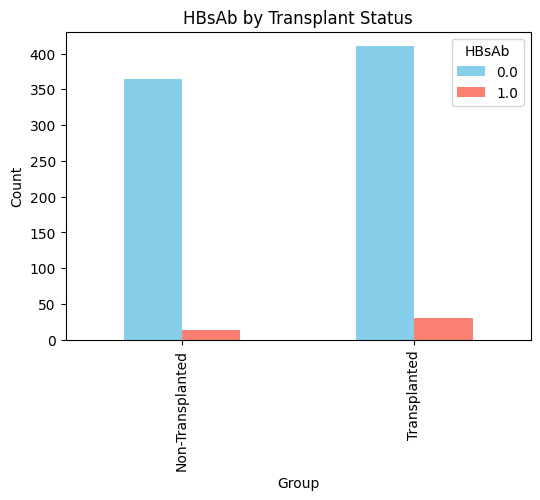

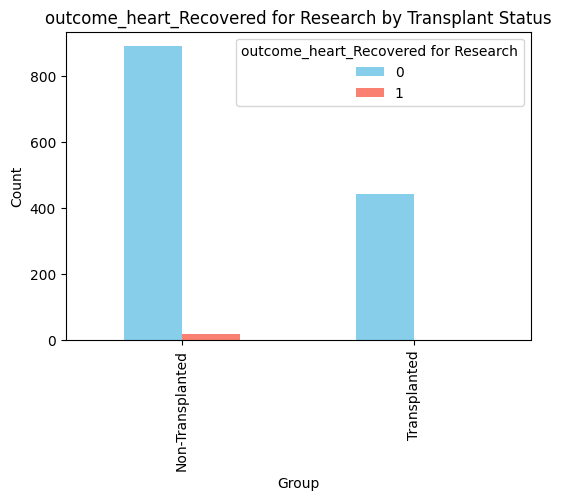

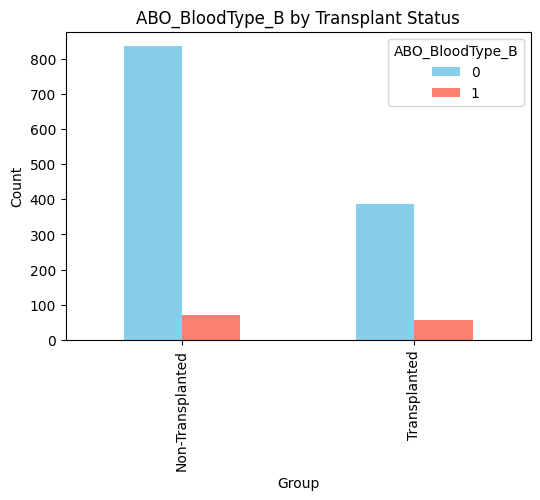

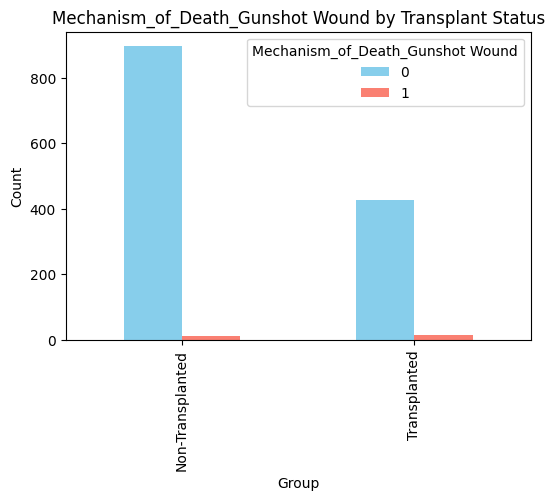

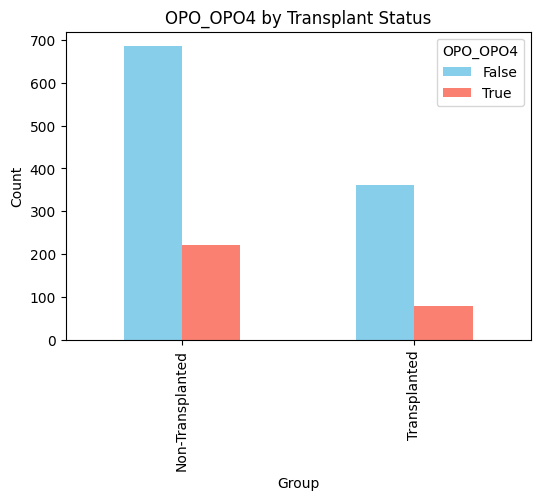

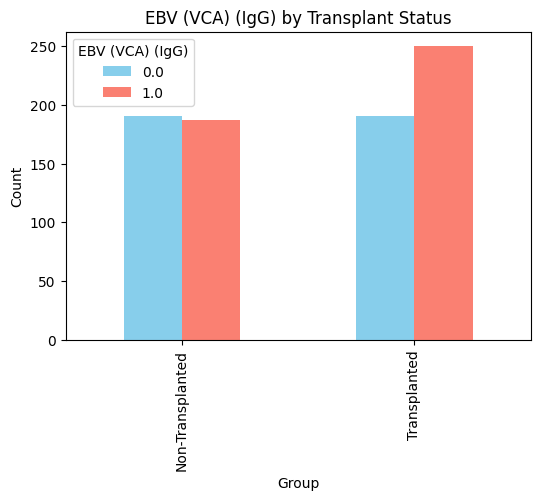

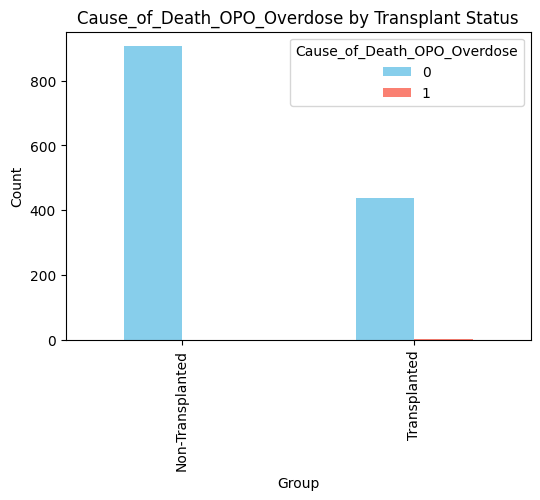

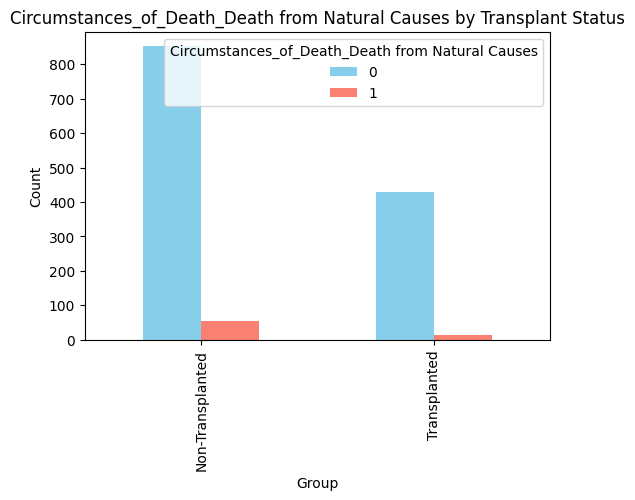

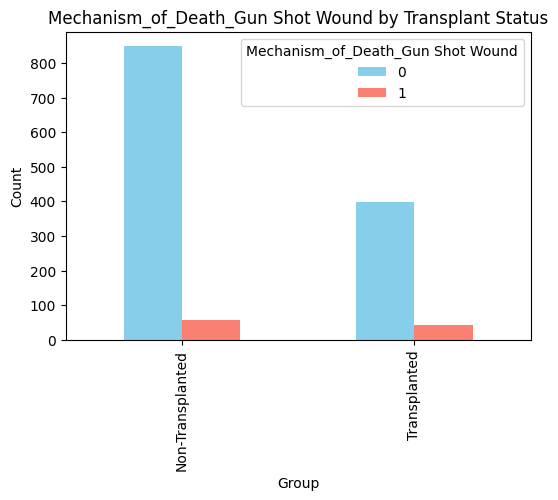

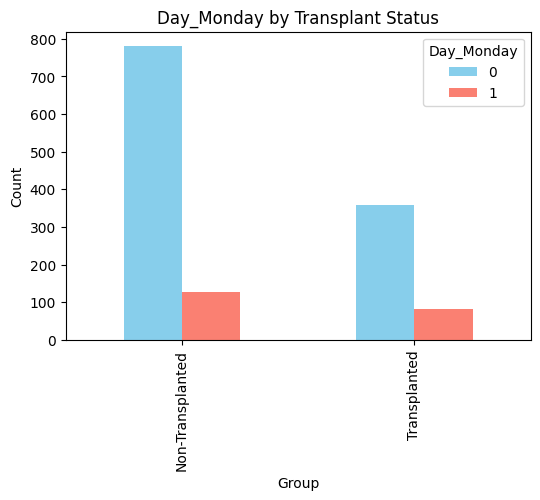

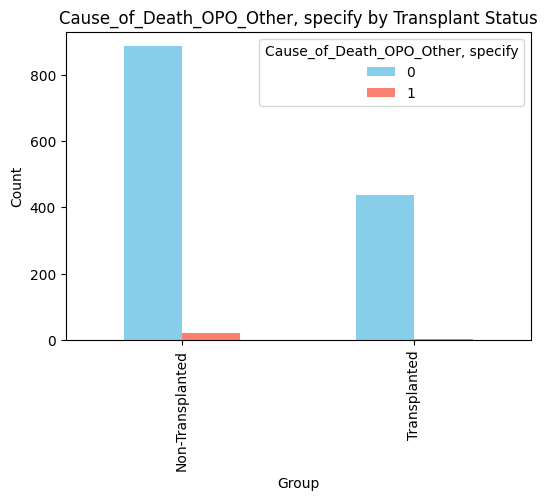

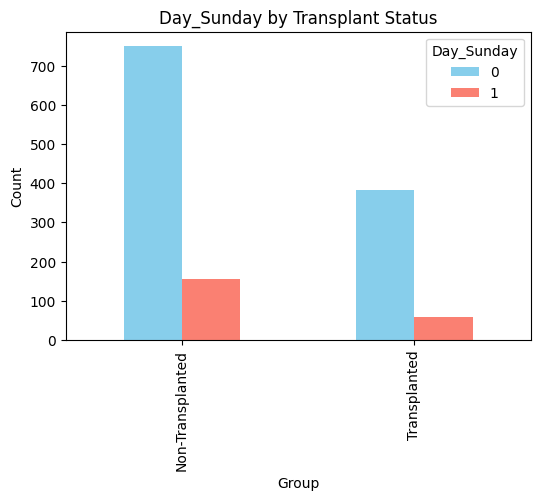

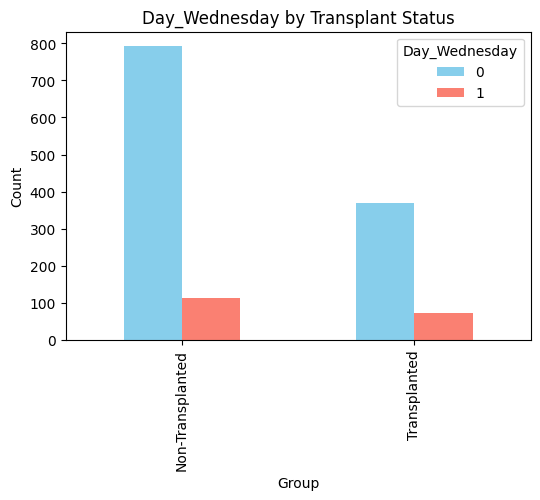

In [109]:

# Pull all variables with correlation p ≤ 0.05
sig_vars = corr_df.loc[corr_df['p_value'] <= 0.05, 'variable'].tolist()

# Prepare a copy of the data with a human‐readable group label
df_vis = peds_heart.copy()
df_vis['group'] = df_vis['outcome_heart_Transplanted'] \
                   .map({0: 'Non-Transplanted', 1: 'Transplanted'})

# Split into continuous (more than 2 uniques) vs. binary flags
cont_vars = [
    v for v in sig_vars
    if pd.api.types.is_numeric_dtype(df_vis[v]) and df_vis[v].nunique() > 2
]
bin_vars = [
    v for v in sig_vars
    if df_vis[v].nunique() == 2
]

# Define colors for the two groups
colors = {
    'Non-Transplanted': 'skyblue',
    'Transplanted':     'salmon'
}

# Plot continuous features: histogram + colored boxplot
for col in cont_vars:
    # Histogram
    plt.figure()
    for grp, color in colors.items():
        df_vis[df_vis['group'] == grp][col] \
            .hist(bins=20, alpha=0.5, label=grp, color=color)
    plt.title(f'Histogram of {col} by Transplant Status')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.legend()
    plt.show()

    # Boxplot with colored boxes and 1.5×IQR whiskers
    data = [df_vis[df_vis['group'] == grp][col].dropna() for grp in colors]
    fig, ax = plt.subplots()
    bp = ax.boxplot(
        data,
        labels=list(colors.keys()),
        patch_artist=True,
        widths=0.6,
        whis=1.5
    )
    for patch, grp in zip(bp['boxes'], colors):
        patch.set_facecolor(colors[grp])
    ax.set_title(f'Boxplot of {col} by Transplant Status')
    ax.set_ylabel(col)
    plt.show()

# Plot binary features: side‑by‑side bar charts of counts
for col in bin_vars:
    ct = df_vis.groupby(['group', col]).size().unstack(fill_value=0)
    ct.plot(
        kind='bar',
        color=['skyblue', 'salmon'],
        figsize=(6,4)
    )
    plt.title(f'{col} by Transplant Status')
    plt.xlabel('Group')
    plt.ylabel('Count')
    plt.legend(title=col)
    plt.show()

#### Final inpsection befre modeling

In [114]:
# Work on a copy
df_clean = peds_heart.copy()

# Find columns where every non‑NA entry is zero
zero_cols = [
    col for col in df_clean.columns
    if df_clean[col].dropna().eq(0).all()
]

print("Dropping all‑zero columns:")
print(zero_cols)

# Permanently drop them
df_clean.drop(columns=zero_cols, inplace=True)



Dropping all‑zero columns:
['Anti HBc', 'Anti HCV', 'Anti HIV 1 and 2', 'Anti-HTLV I/II', 'Chagas', 'Chagas NAT', 'Confirmatory - Syphilis', 'EBV', 'EBV IgM', 'HBV DNA', 'HBV NAT', 'HBV_NAT', 'HBc Total', 'HBcAB IgM', 'HBsAg#', 'HCV Ab', 'HCV NAT', 'HCV NAT (TMA)', 'HCV RNA', 'HCV_AB', 'HCV_NAT', 'HIV', 'HIV 1/2 plus O Ab', 'HIV Ag/Ab Combo', 'HIV Ag/Ab Combo Assay', 'HIV I/II', 'HIV NAT', 'HIV NAT (TMA)', 'HIV O EIA', 'HIV-1 RNA', 'HIV-1/HCV/HBV NAT (ULTRIO)', 'HIV-1/HCV/HBV NAT Ultrio', 'HIV_NAT', 'HTLV I/II', 'HTLV I/II AB', 'HTLV NAT', 'HTLV_I_II', 'HbsAg', 'Hepatitis BC Ab', 'Hepatitis Bs Ag', 'Hepatitis C Ab', 'MHATP', 'NAT HBV', 'NAT HCV', 'NAT HIV', 'Other5', 'RPR', 'RPR#', 'RPR/VDRL', 'WNV', 'WNV NAT', 'WNV RNA']

New shape: (1347, 182)

Column list:
['Age', 'Gender', 'brain_death', 'HeightIn', 'WeightKg', 'transplanted', 'Tissue_Referral', 'Eye_Referral', 'Referral_Year', 'Procured_Year', 'Blood', 'CSF', 'L Bronch', 'L Bronch Gm St', 'Lung', 'Other', 'R Bronch', 'R Bronch Gm 

In [116]:
# Standardize a string version of each column’s non‑NA values
str_vals = {}
for col in df_clean.columns:
    # convert non‑NA to uppercase strings
    non_na = df_clean[col].dropna().astype(str).str.strip().str.upper()
    str_vals[col] = set(non_na.unique())

# Identify boolean‑style columns (True/False)
bool_cols = [
    col for col in df_clean.columns
    if str_vals[col].issubset({'TRUE','FALSE'})
]

# Identify Y/N columns
yn_cols = [
    col for col in df_clean.columns
    if str_vals[col].issubset({'Y','N'})
]

# Identify YES/NO columns
yesno_cols = [
    col for col in df_clean.columns
    if str_vals[col].issubset({'YES','NO'})
]

# Report
print("Boolean (TRUE/FALSE) columns:")
print(bool_cols)
print("\nY/N columns:")
print(yn_cols)
print("\nYES/NO columns:")
print(yesno_cols)


Boolean (TRUE/FALSE) columns:
['OPO_OPO1', 'OPO_OPO2', 'OPO_OPO3', 'OPO_OPO4', 'OPO_OPO5', 'OPO_OPO6']

Y/N columns:
[]

YES/NO columns:
[]


In [118]:
bool_cols = ['OPO_OPO1', 'OPO_OPO2', 'OPO_OPO3', 'OPO_OPO4', 'OPO_OPO5', 'OPO_OPO6']
# Convert True/False → 1/0 for all OPO flags
df_clean[bool_cols] = df_clean[bool_cols].astype(int)

# Verify
print(df_clean[bool_cols].head())
print(df_clean[bool_cols].dtypes)


     OPO_OPO1  OPO_OPO2  OPO_OPO3  OPO_OPO4  OPO_OPO5  OPO_OPO6
112         1         0         0         0         0         0
131         1         0         0         0         0         0
176         1         0         0         0         0         0
240         1         0         0         0         0         0
262         1         0         0         0         0         0
OPO_OPO1    int32
OPO_OPO2    int32
OPO_OPO3    int32
OPO_OPO4    int32
OPO_OPO5    int32
OPO_OPO6    int32
dtype: object


                     missing_count  missing_percent
Sputum Gm St                   650        48.255382
Lung                           650        48.255382
Wound                          650        48.255382
Urine                          650        48.255382
Sputum                         650        48.255382
R Bronch Gm St                 650        48.255382
R Bronch                       650        48.255382
Other                          650        48.255382
L Bronch Gm St                 650        48.255382
L Bronch                       650        48.255382
CSF                            650        48.255382
Blood                          650        48.255382
Procured_Year                  622        46.176689
Intake_Crystalloid             621        46.102450
Output_Urine                   621        46.102450
Output_NonUrine                621        46.102450
Intake_Total                   621        46.102450
Intake_Colloid                 621        46.102450
Intake_Blood